<a href="https://colab.research.google.com/github/AdnaneMOUZAOUI/Projet-Analyse-de-la-supplay-chain/blob/main/Code_complet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importation des packages**

In [ ]:
# Importation des librairies utiles au projet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import re
import string
import multiprocessing
import xgboost as xgb
import joblib
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import ngrams
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

try :
  import shap
  import selenium
except : # Nécessaire pour Colab
  !pip install shap
  !pip install selenium
  import shap
  import selenium

from time import sleep
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

# Reste du code

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# Si utilisation de Google Colab :
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Drive non connecté")

Mounted at /content/drive


# **Scrapping des données**

In [ ]:
# importation des packages

import warnings
warnings.filterwarnings("ignore")

options = webdriver.ChromeOptions()

#options.add_argument('-headlesss')
#options.add_argument('-no-sandbox')
#options.add_argument('-desable-dev-shm-usage')

driver = webdriver.Chrome()


driver.get("https://fr.trustpilot.com/review/www.showroomprive.com")

#driver.get("https://fr.trustpilot.com/review/www.showroomprive.com")



bouton_rejet_cookies = driver.find_element(by='id', value="onetrust-reject-all-handler")

bouton_rejet_cookies.click()

# attendre 3 seconde
sleep(3)





j = 0
df =pd.DataFrame(columns=['nom_client',
                         'note_avis',
                         'date_achat',
                         'date_avis',
                         'nbr_avis',
                         'text_avis',
                         'pays',
                         'titre_avis'])

for k in range(5000):

    # chercher les sections comportant les avis et infos correspondantes
    sections = driver.find_elements(By.XPATH,'//section[@class="styles_reviewContentwrapper__zH_9M"]')


    # mettre pour chaque varibale une liste de webelemnts qui regroupera les 20 résultats par page

    nom_client  = driver.find_elements(By.XPATH,
                                    '//span[@class="typography_heading-xxs__QKBS8 typography_appearance-default__AAY17"]')
#-----------------------------------------------------------

    note_avis   = driver.find_elements(By.CLASS_NAME,
                             'styles_reviewHeader__iU9Px')

# ----------------------------------------------------

#    date_avis = driver.find_elements(By.TAG_NAME,'time')

#    date_avis = driver.find_elements(By.XPATH,
#                                     '//section[@class="styles_reviewContentwrapper__zH_9M"]/div/div/time')

    date_avis=[]
    for h in range(20):
        date = sections[h].find_element(By.TAG_NAME, 'time').get_attribute('datetime')
        date_avis.append(date)
# -------------------------------------------------------------------

    date_achat  = driver.find_elements(By.XPATH,
                                          '//p[@class="typography_body-m__xgxZ_ typography_appearance-default__AAY17 typography_color-black__5LYEn"]')
# ---------------------------------------------------------

    nbr_avis = driver.find_elements(By.XPATH, '//div[@class="styles_consumerExtraDetails__fxS4S"]')

#-------------------------------------------------------------

#    text_avis   = driver.find_elements(By.XPATH,
#                                '//p[@class="typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn"]')

    text_avis = []
    for section in sections:
        try:
            sec = section.find_element(By.TAG_NAME,'p').text
        except Exception :
            sec = np.Nan
        text_avis.append(sec)
# --------------------------------------------------------------

    pays = driver.find_elements(By.XPATH,
                           '//div[@class="typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua"]/span')

# ---------------------------------------------------------------

    titre_avis = driver.find_elements(By.XPATH,
                                    '//h2[@class="typography_heading-s__f7029 typography_appearance-default__AAY17"]')



# ***************************************************************

    # remplir le data frame avec les infos récupérées

    #l = len(text_avis)

    for i in range(20):

        df.loc[j,'nom_client']  = nom_client[i].text

        df.loc[j, 'note_avis']  = note_avis[i].get_attribute('data-service-review-rating')   # Extraire unqiuement le rating review

        df.loc[j, 'date_achat'] = date_achat[i]       # récuprer la ligne complète de date, ensuite, extraite uniquement la date

        df.loc[j, 'date_achat'] = date_achat[i].text[20:]

        df.loc[j, 'date_avis']  = date_avis[i][:10]  #Checher la ligne datetime, esnuite extraite la date

        df.loc[j, 'nbr_avis']   = nbr_avis[i].get_attribute('data-consumer-reviews-count')

        df.loc[j, 'text_avis']  = text_avis[i]

        df.loc[j, 'pays']       = pays[i].text

        df.loc[j, 'titre_avis'] = titre_avis[i].text

        j = j+1

# ***************************************************************
    # passer à la page suivante
    page_suivante = driver.find_element(By.NAME,'pagination-button-next')

    driver.execute_script("arguments[0].click();", page_suivante)

    # patienter 2 secondes pour que la page se charge correctement
    sleep(2)

***************************************************

In [ ]:
# Les résultats du scraping exportés au format csv sous le nom de
# showroom_trustpilot_168897_07 mars2.csv

# **Transformation des données**

In [ ]:
# Importation des données scrappées
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/showroom_trustpilot_168897_07 mars2.csv') #ligne pour récupérer les données sur G-Drive
except:
    df = pd.read_csv('showroom_trustpilot_168897_07 mars2.csv')

In [ ]:
# Renommage des colonnes
df=df.rename(columns={"nom_client":"client","date_achat":"date_commande","date_avis":"date","text_avis":"Commentaire","titre_avis":"Titre","note_avis":"star"})

# Instanciation du lemmatizer
lemmatizer = WordNetLemmatizer()

# Paramétrage des stopwords
commentaires = pd.Series(df['Commentaire'])
stop_words = set(stopwords.words('french'))
stop_words.update(['a', "jai", "cest", "sest", "car", "donc"])
stop_words.difference_update(["pas","ne"])

# Instanciation d'une fonction pour supprimer les espaces superflus, mettre les mots en minuscule et retirer les ponctuations
def clean_text(text):
    text = " ".join(text.split())
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Instanciation d'une fonction qui compte les mots
def count_words(text):
    return len(text.split())

# Calcule de la longueur de chaque commentaire
df['longueur'] = commentaires.apply(lambda x: len(x) if isinstance(x, str) else 0) #isinstance vérifie si x est un str

# Calcule du nombre de majuscules dans chaque commentaire
df['majuscule'] = commentaires.apply(lambda x: sum(1 for c in x if c.isupper()) if isinstance(x, str) else 0)

# Calcule du nombre de points d'exclamation et d'interrogation dans chaque commentaire
df['ponct'] = commentaires.apply(lambda x: x.count('!') + x.count('?') if isinstance(x, str) else 0)

# Comptage du nombre de mots dans chaque commentaire
df['nb_mots'] = commentaires.apply(lambda x: count_words(x) if isinstance(x, str) else 0)

# Nettoyage du texte de chaque commentaire, lemmatisation et comptage de la fréquence des mots
for x in tqdm(range(0,df.shape[0])):
    try: #Dans l'hypothèse où le jeu de données comporterait des valeurs manquantes dans les commentaires (ce qui n'est ici pas le cas)
        filtered_sentence = []
        commentaires[x] = clean_text(commentaires[x])
        word_tokens = word_tokenize(commentaires[x], language="french")
        for w in word_tokens:
            if not w in stop_words and w.isalpha():
                lemma = lemmatizer.lemmatize(w)
                filtered_sentence.append(lemma)
        commentaires[x] = filtered_sentence
    except:
        commentaires[x] = ""
df['Commentaire'] = commentaires

# Créer des n-grammes de taille 2 et 3
df['ngram_2'] = commentaires.apply(lambda x: list(ngrams(x, 2)) if isinstance(x, list) else [])
df['ngram_3'] = commentaires.apply(lambda x: list(ngrams(x, 3)) if isinstance(x, list) else [])


# Même processus que pour les commentaires, mais pour les titres des commentaires :

titres = pd.Series(df['Titre'])
df['longueur_titre'] = titres.apply(lambda x: len(x) if isinstance(x, str) else 0)
df['majuscule_titre'] = titres.apply(lambda x: sum(1 for c in x if c.isupper()) if isinstance(x, str) else 0)
df['ponct_titre'] = titres.apply(lambda x: x.count('!') + x.count('?') if isinstance(x, str) else 0)
df['nb_mots_titre'] = titres.apply(lambda x: count_words(x) if isinstance(x, str) else 0)
for x in tqdm(range(0,df.shape[0])):
    try:
        filtered_sentence = []
        titres[x] = clean_text(titres[x])
        word_tokens = word_tokenize(titres[x], language="french")
        for w in word_tokens:
            if not w in stop_words and w.isalpha():
                lemma = lemmatizer.lemmatize(w)
                filtered_sentence.append(lemma)
        titres[x] = filtered_sentence
    except:
        titres[x] = ""
df['Titre'] = titres
df['ngram_2_titre'] = titres.apply(lambda x: list(ngrams(x, 2)) if isinstance(x, list) else [])
df['ngram_3_titre'] = titres.apply(lambda x: list(ngrams(x, 3)) if isinstance(x, list) else [])


# Dichotomisation des Commentaires et Titres (utilisée avant de connaitre le count vectorizer)
# Uniquement sur les tops 20 des mots, et n_grams

# réinitialisation des compteurs
compteur_mots_com = Counter()
compteur_ngrams_2_com = Counter()
compteur_ngrams_3_com = Counter()
compteur_mots_titre = Counter()
compteur_ngrams_2_titre = Counter()
compteur_ngrams_3_titre = Counter()

for x in range(0,df.shape[0]):
    mots = df.loc[x, 'Commentaire']
    ngrams_2 = df.loc[x, 'ngram_2']
    ngrams_3 = df.loc[x, 'ngram_3']
    compteur_mots_com.update(mots)
    compteur_ngrams_2_com.update(ngrams_2)
    compteur_ngrams_3_com.update(ngrams_3)
    mots_t = df.loc[x, 'Titre']
    ngrams_2_t = df.loc[x, 'ngram_2_titre']
    ngrams_3_t = df.loc[x, 'ngram_3_titre']
    compteur_mots_titre.update(mots_t)
    compteur_ngrams_2_titre.update(ngrams_2_t)
    compteur_ngrams_3_titre.update(ngrams_3_t)

# Dichotomisation des Commentaires
df['Commentaire'].fillna('', inplace=True)
mots_cles = [mot for mot, _ in compteur_mots_com.most_common(20)] #on utilise ", _" pour indiquer que l'on veut stocker uniquement le premier élement de 'most_common(), et non pas le compte d'apparition
for mot in mots_cles:
    df['Commentaire_'+mot] = df['Commentaire'].apply(lambda x: int(mot in x)) #int pour convertir le booléen en entier

# Dichotomisation des commentaires ngrams2
df['ngram_2'].fillna('', inplace=True)
mots_cles = [mot for mot, _ in compteur_ngrams_2_com.most_common(20)] #on utilise ", _" pour indiquer que l'on veut stocker uniquement le premier élement de 'most_common(), et non pas le compte d'apparition
for mot in mots_cles:
    df['ngrams_2_'+str(mot)] = df['ngram_2'].apply(lambda x: int(any(mot == t for t in x)))

# Dichotomisation des commentaires ngrams3
df['ngram_3'].fillna('', inplace=True)
mots_cles = [mot for mot, _ in compteur_ngrams_3_com.most_common(20)] #on utilise ", _" pour indiquer que l'on veut stocker uniquement le premier élement de 'most_common(), et non pas le compte d'apparition
for mot in mots_cles:
    df['ngrams_3_'+str(mot)] = df['ngram_3'].apply(lambda x: int(any(mot == t for t in x)))

# Dichotomisation des titres
df['Titre'].fillna('', inplace=True)
mots_cles = [mot for mot, _ in compteur_mots_titre.most_common(20)] #on utilise ", _" pour indiquer que l'on veut stocker uniquement le premier élement de 'most_common(), et non pas le compte d'apparition
for mot in mots_cles:
    df['Titre_'+mot] = df['Titre'].apply(lambda x: int(mot in x)) #int pour convertir le booléen en entier

# Dichotomisation des titres ngrams2
df['ngram_2_titre'].fillna('', inplace=True)
mots_cles = [mot for mot, _ in compteur_ngrams_2_titre.most_common(20)] #on utilise ", _" pour indiquer que l'on veut stocker uniquement le premier élement de 'most_common(), et non pas le compte d'apparition
for mot in mots_cles:
    df['ngrams_2_titre_'+str(mot)] = df['ngram_2'].apply(lambda x: int(any(mot == t for t in x)))

# Dichotomisation des titres ngrams3
df['ngram_3_titre'].fillna('', inplace=True)
mots_cles = [mot for mot, _ in compteur_ngrams_3_titre.most_common(20)] #on utilise ", _" pour indiquer que l'on veut stocker uniquement le premier élement de 'most_common(), et non pas le compte d'apparition
for mot in mots_cles:
    df['ngrams_3_titre'+str(mot)] = df['ngram_3_titre'].apply(lambda x: int(any(mot == t for t in x)))

df['star_cluster'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)

# Export du dataframe à cette étape
df.to_csv('data_preparee2.csv')

100%|██████████| 168897/168897 [00:30<00:00, 5522.03it/s]
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

# **Analyse des données**

In [ ]:
# # Nécessite l'execution de la section précédente

##Comptage de mots

In [ ]:
# Comptage de la fréquence des mots dans les commentaires

compteur_mots = Counter()
compteur_ngrams_2 = Counter()
compteur_ngrams_3 = Counter()

for x in range(0,df.shape[0]):
    mots = df.loc[x, 'Commentaire']
    ngrams_2 = df.loc[x, 'ngram_2']
    ngrams_3 = df.loc[x, 'ngram_3']
    compteur_mots.update(mots)
    compteur_ngrams_2.update(ngrams_2)
    compteur_ngrams_3.update(ngrams_3)

print("20 mots les plus communs :")
for Commentaire, frequence in compteur_mots.most_common(20):
    print(Commentaire, frequence)

print("\n 20 2-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_2.most_common(20):
    print(ngram, frequence)

print("\n 20 3-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_3.most_common(20):
    print(ngram, frequence)

20 mots les plus communs :
pa 62749
commande 56221
livraison 48559
très 42398
ne 31072
bien 25659
colis 25619
site 24226
plus 23735
produits 21646
produit 21337
article 18585
qualité 16756
tout 16474
bon 16045
reçu 15087
délais 13681
prix 13328
trop 12925
long 12839

 20 2-ngrams les plus communs :
('ne', 'pa') 6984
('délai', 'livraison') 5899
('très', 'bien') 5658
('délais', 'livraison') 5497
('nest', 'pa') 4833
('trop', 'long') 4766
('service', 'client') 4570
('point', 'relais') 4465
('très', 'bon') 4103
('bonne', 'qualité') 3820
('frais', 'port') 3758
('nai', 'pa') 3713
('très', 'satisfaite') 3511
('peu', 'long') 3466
('rien', 'dire') 3240
('date', 'lexpérience') 2935
('livraison', 'trop') 2895
('livraison', 'peu') 2832
('bien', 'passé') 2613
('produit', 'conforme') 2432

 20 3-ngrams les plus communs :
('livraison', 'trop', 'long') 1585
('livraison', 'peu', 'long') 1364
('très', 'bon', 'site') 1334
('tout', 'bien', 'passé') 1221
('ne', 'correspond', 'pa') 1146
('rapport', 'qualité'

In [ ]:
# Comptage de la fréquence des mots dans les titres

compteur_mots = Counter()
compteur_ngrams_2 = Counter()
compteur_ngrams_3 = Counter()

for x in range(0,df.shape[0]):
    mots = df.loc[x, 'Titre']
    ngrams_2 = df.loc[x, 'ngram_2_titre']
    ngrams_3 = df.loc[x, 'ngram_3_titre']
    compteur_mots.update(mots)
    compteur_ngrams_2.update(ngrams_2)
    compteur_ngrams_3.update(ngrams_3)

print("20 mots les plus communs :")
for Commentaire, frequence in compteur_mots.most_common(20):
    print(Commentaire, frequence)

print("\n 20 2-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_2.most_common(20):
    print(ngram, frequence)

print("\n 20 3-ngrams les plus communs :")
for ngram, frequence in compteur_ngrams_3.most_common(20):
    print(ngram, frequence)

20 mots les plus communs :
très 17786
commande 16985
livraison 15925
bien 14459
satisfaite 8805
bon 8780
pa 8685
parfait 7525
produit 6963
site 6822
super 4863
trop 4801
qualité 4418
tres 4372
colis 4223
produits 4052
excellent 3864
long 3846
conforme 3747
déçue 3696

 20 2-ngrams les plus communs :
('très', 'bien') 5447
('bon', 'site') 2708
('très', 'bon') 2599
('très', 'satisfaite') 2190
('trop', 'long') 2169
('délai', 'livraison') 1790
('livraison', 'trop') 1786
('bon', 'produit') 1692
('tres', 'bien') 1644
('délais', 'livraison') 1132
('rien', 'dire') 941
('trop', 'longue') 895
('bien', 'passé') 773
('non', 'conforme') 764
('très', 'déçue') 718
('bonne', 'qualité') 707
('rien', 'redire') 689
('peu', 'long') 664
('très', 'contente') 646
('retard', 'livraison') 640

 20 3-ngrams les plus communs :
('très', 'bon', 'site') 1234
('livraison', 'trop', 'long') 862
('livraison', 'trop', 'longue') 602
('rapport', 'qualité', 'prix') 471
('très', 'bon', 'produit') 420
('délai', 'livraison', '

##WordClouds

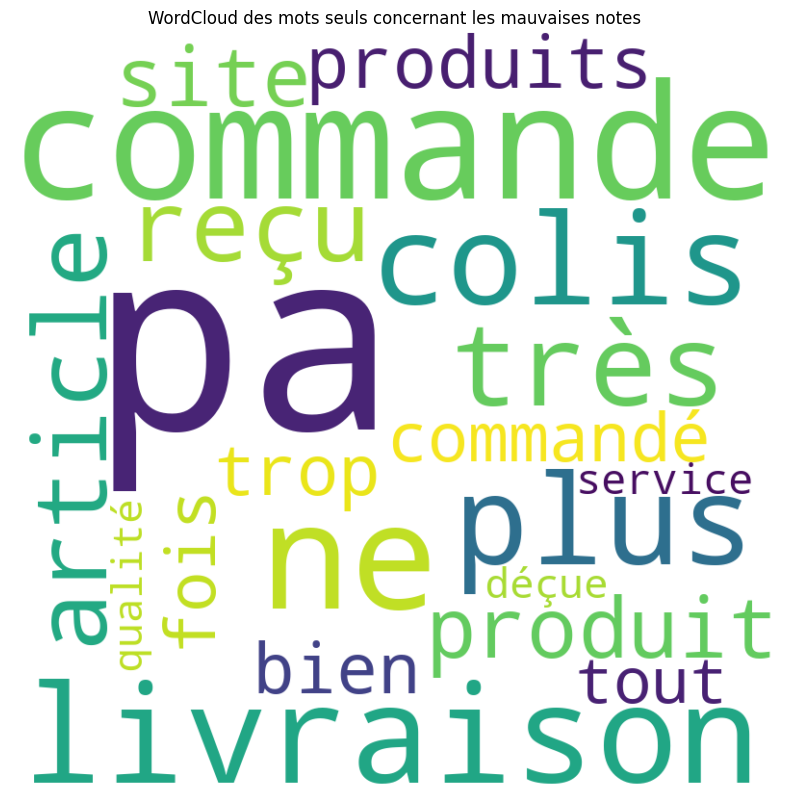

In [ ]:
# Wordclouds pour les mots des commentaires négatifs

text = ' '.join([' '.join(lst) for lst in df[(df['star'] == 1) | (df['star'] == 2) | (df['star']==3)]['Commentaire']])
wordcloud = WordCloud(background_color = 'white', max_words=20,width=800, height=800, stopwords=[], collocations=False,normalize_plurals=False )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots seuls concernant les mauvaises notes")
plt.show()

wordcloud.to_file("WCbad_1.png")

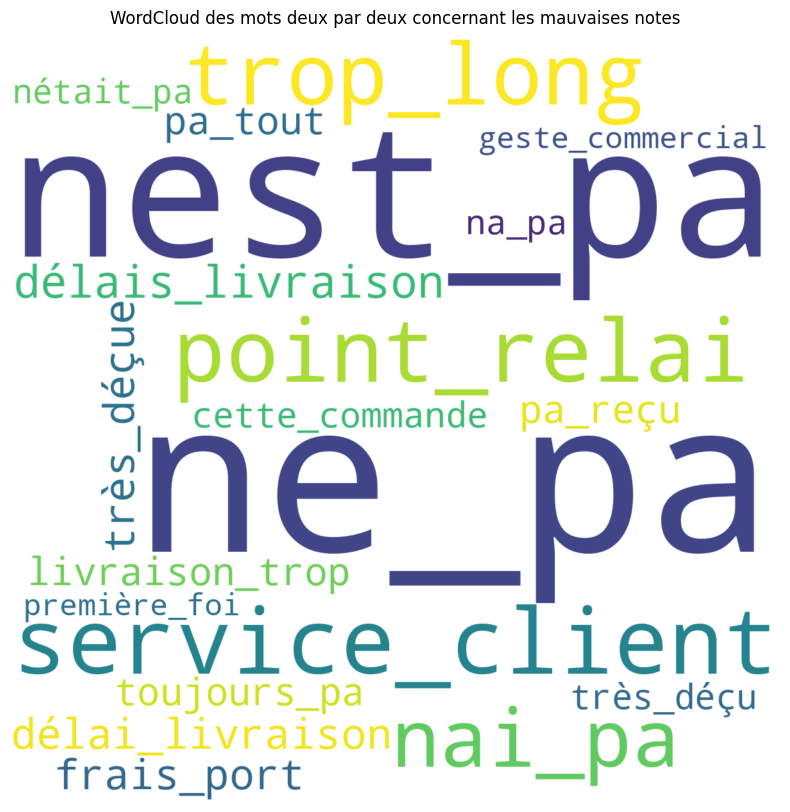

In [ ]:
# Wordclouds pour les 2-grams des commentaires négatifs

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 1) | (df['star'] == 2) | (df['star']==3)]['ngram_2'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots deux par deux concernant les mauvaises notes")
plt.show()
wordcloud.to_file("WCbad_2.png")

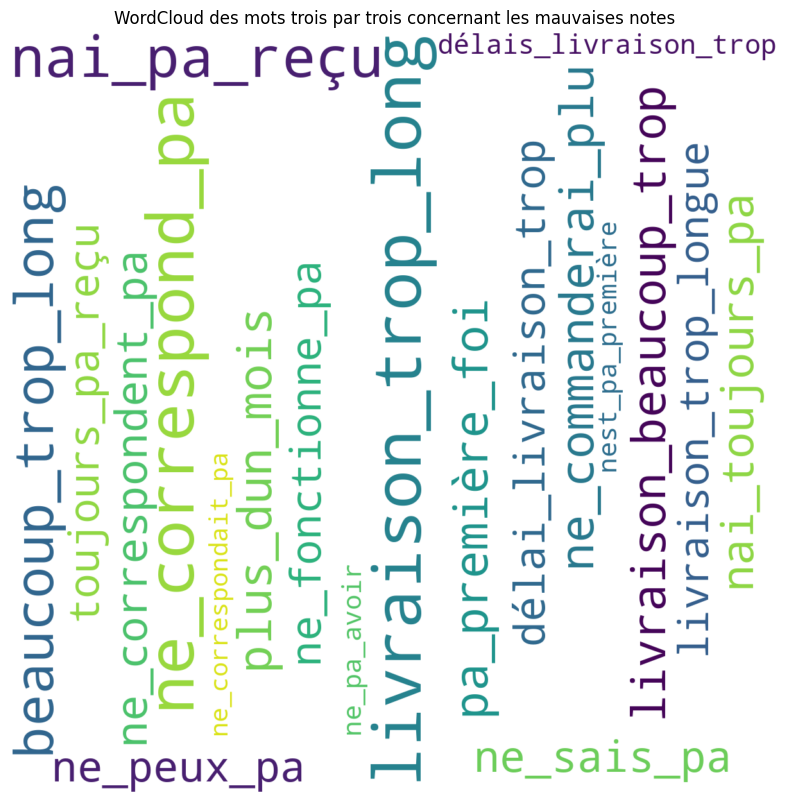

In [ ]:
# Wordclouds pour les 3-grams des commentaires négatifs

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 1) | (df['star'] == 2) | (df['star']==3)]['ngram_3'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots trois par trois concernant les mauvaises notes")
plt.show()
wordcloud.to_file("WCbad_3.png")

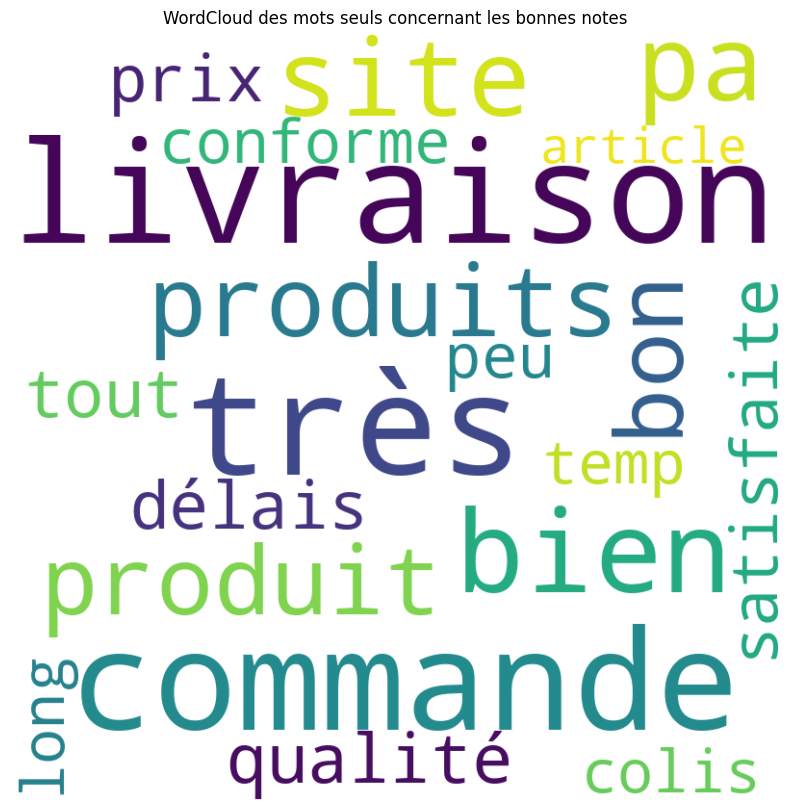

In [ ]:
# Wordclouds pour les mots des commentaires positifs

text = ' '.join([' '.join(lst) for lst in df[(df['star'] == 4) | (df['star'] == 5)]['Commentaire']])
wordcloud = WordCloud(background_color = 'white', max_words=20,width=800, height=800, stopwords=[], collocations=False,normalize_plurals=False  )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots seuls concernant les bonnes notes")
plt.show()
wordcloud.to_file("WCgood_1.png")

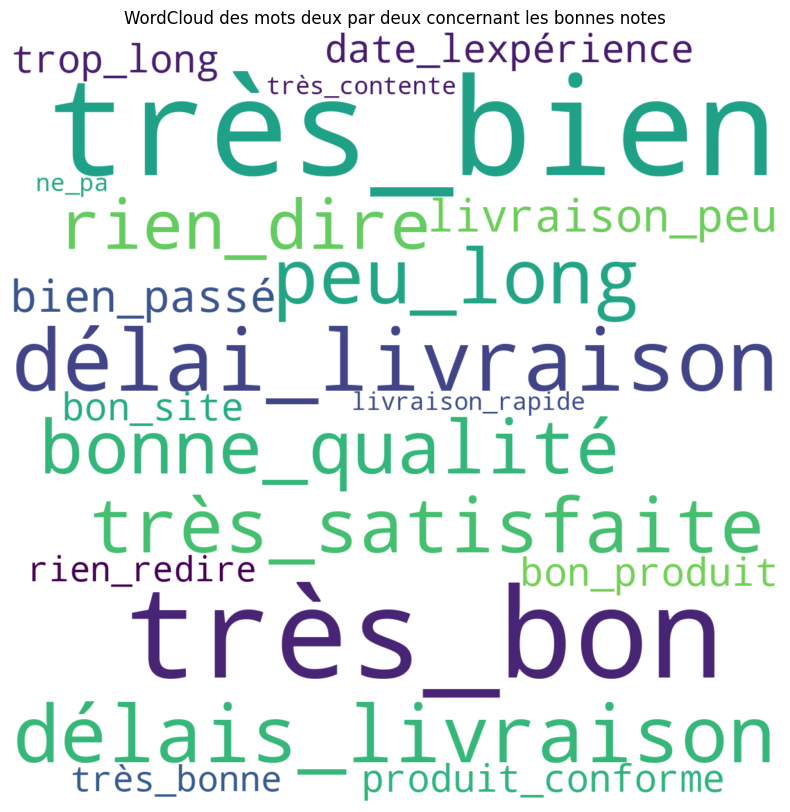

In [ ]:
# Wordclouds pour les 2-grams des commentaires positifs

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 4) | (df['star'] == 5)]['ngram_2'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots deux par deux concernant les bonnes notes")
plt.show()
wordcloud.to_file("WCgood_2.png")

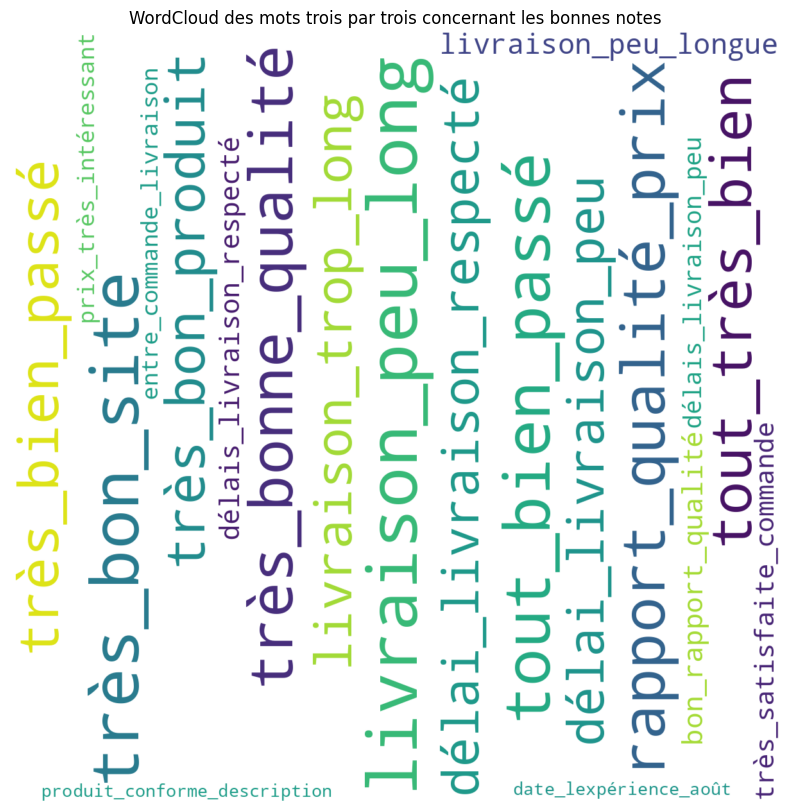

In [ ]:
# Wordclouds pour les 3-grams des commentaires positifs

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 4) | (df['star'] == 5)]['ngram_3'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots trois par trois concernant les bonnes notes")
plt.show()
wordcloud.to_file("WCgood_3.png")

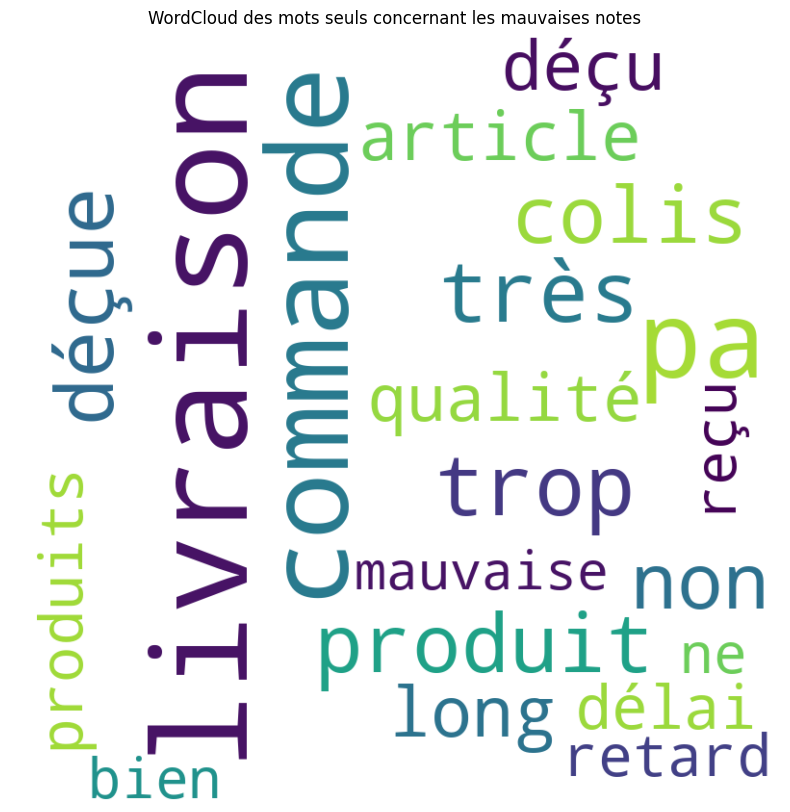

In [ ]:
# Wordclouds pour les mots des titres des commentaires négatifs

text = ' '.join([' '.join(lst) for lst in df[(df['star'] == 1) | (df['star'] == 2) | (df['star']==3)]['Titre']])
wordcloud = WordCloud(background_color = 'white', max_words=20,width=800, height=800, stopwords=[], collocations=False,normalize_plurals=False )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots seuls concernant les mauvaises notes")
plt.show()

wordcloud.to_file("WCbad_1_titre.png")

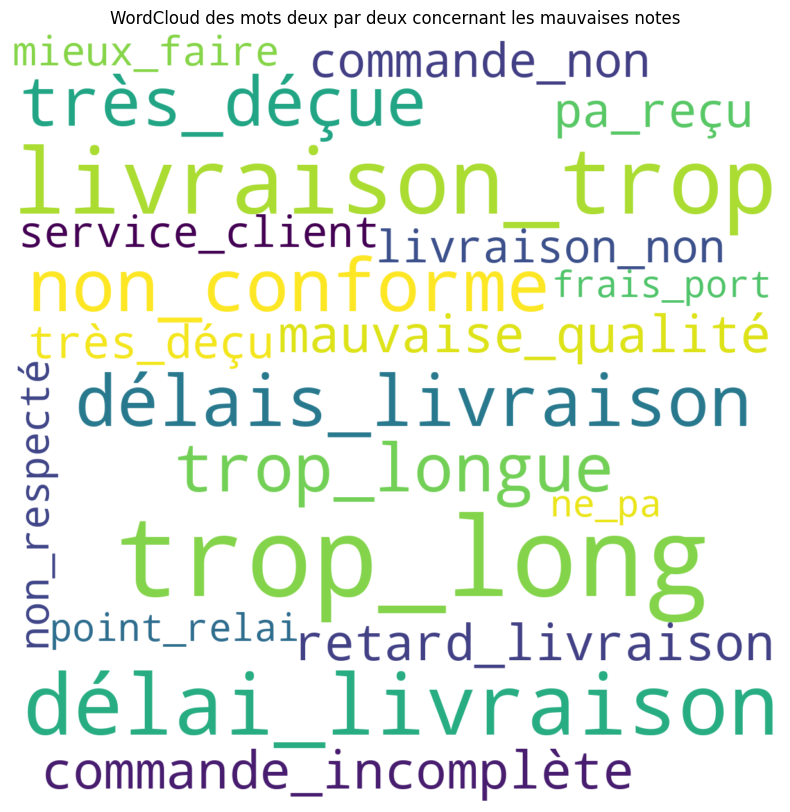

In [ ]:
# Wordclouds pour les 2-grams des titres des commentaires négatifs

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 1) | (df['star'] == 2) | (df['star']==3)]['ngram_2_titre'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots deux par deux concernant les mauvaises notes")
plt.show()
wordcloud.to_file("WCbad_2_titre.png")

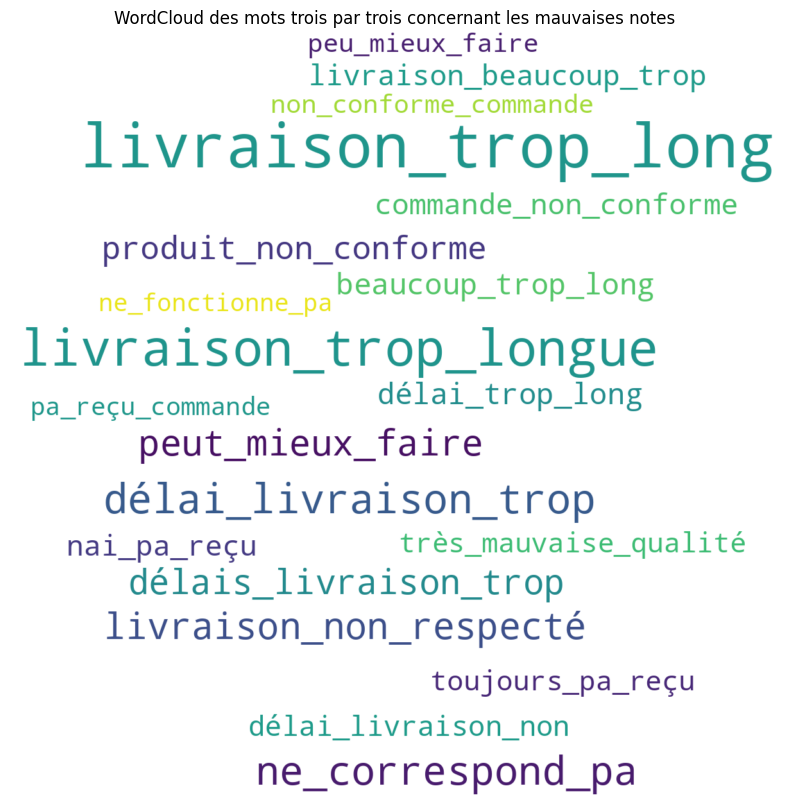

In [ ]:
# Wordclouds pour les 3-grams des titres des commentaires négatifs

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 1) | (df['star'] == 2) | (df['star']==3)]['ngram_3_titre'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots trois par trois concernant les mauvaises notes")
plt.show()
wordcloud.to_file("WCbad_3_titre.png")

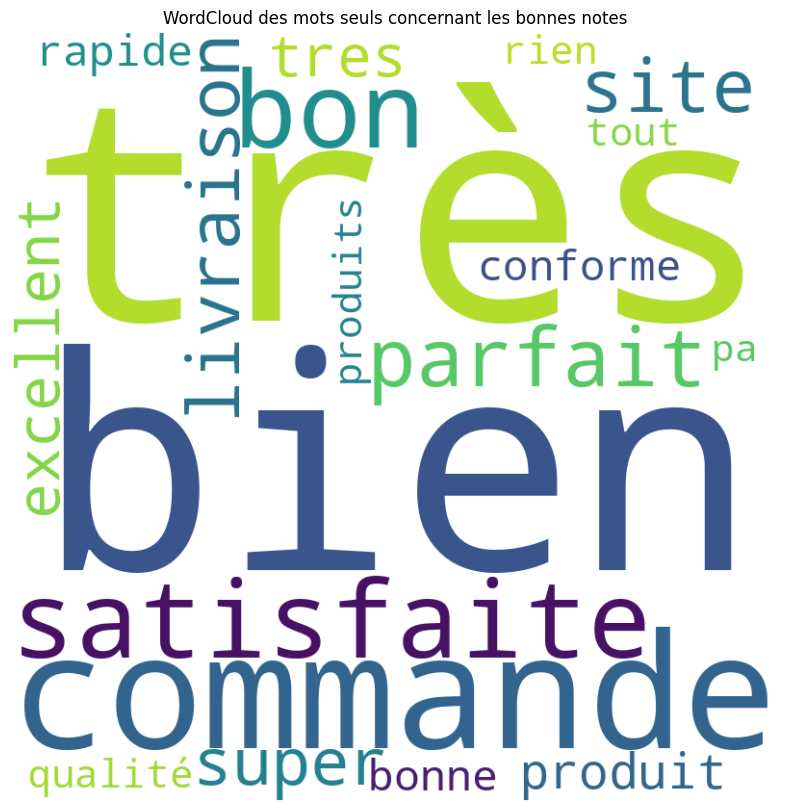

In [ ]:
# Wordclouds pour les mots des titres des commentaires positifs

text = ' '.join([' '.join(lst) for lst in df[(df['star'] == 4) | (df['star'] == 5)]['Titre']])
wordcloud = WordCloud(background_color = 'white', max_words=20,width=800, height=800, stopwords=[], collocations=False,normalize_plurals=False  )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots seuls concernant les bonnes notes")
plt.show()
wordcloud.to_file("WCgood_1_titre.png")

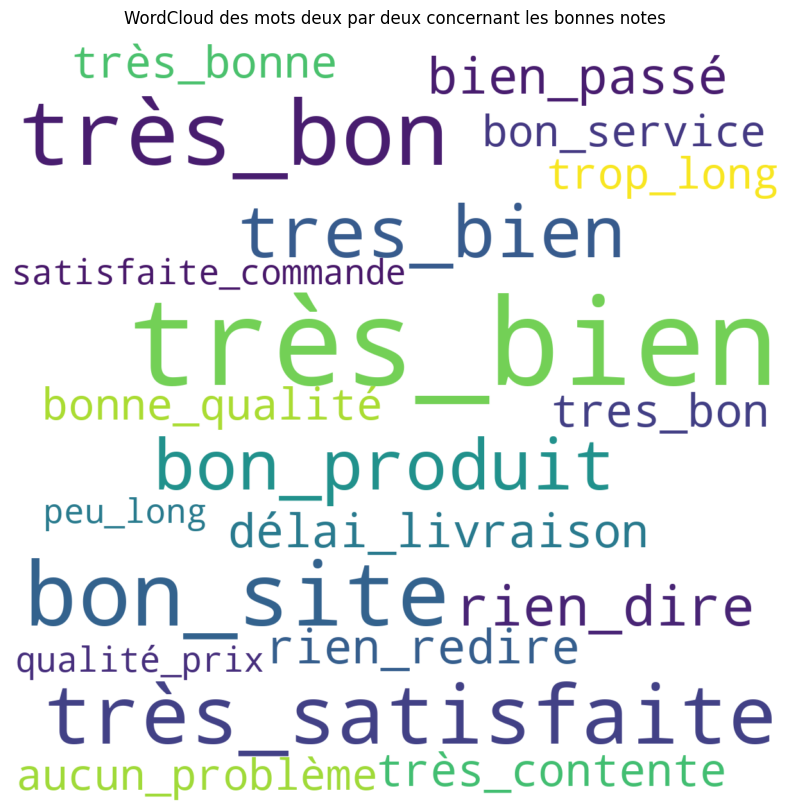

In [ ]:
# Wordclouds pour les 2-grams des titres des commentaires positifs

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 4) | (df['star'] == 5)]['ngram_2_titre'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots deux par deux concernant les bonnes notes")
plt.show()
wordcloud.to_file("WCgood_2_titre.png")

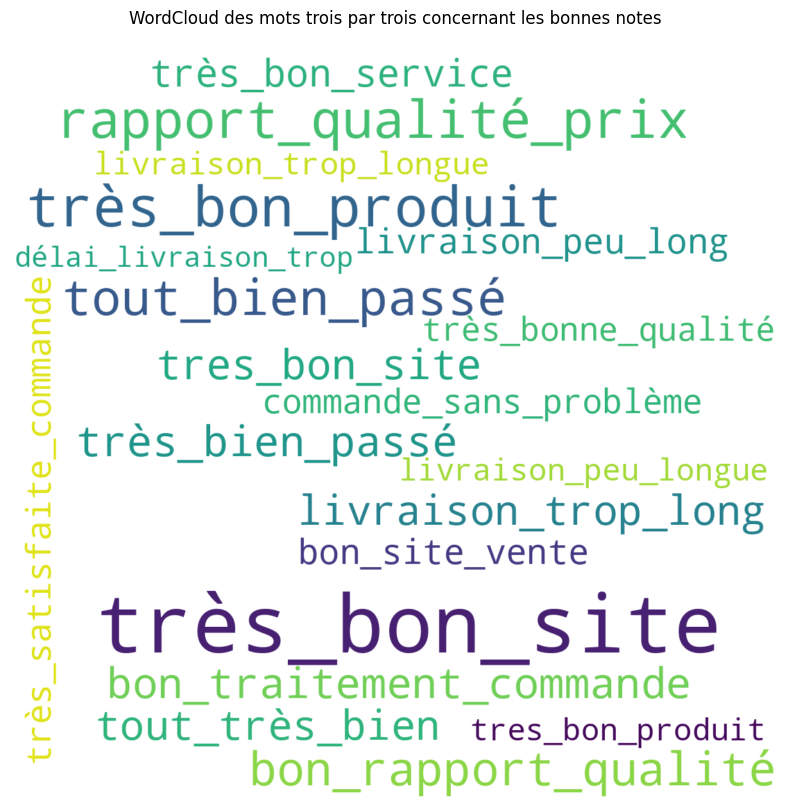

In [ ]:
# Wordclouds pour les 3-grams des titres des commentaires positifs

text = ' '.join(['_'.join(pair) for lst in df[(df['star'] == 4) | (df['star'] == 5)]['ngram_3_titre'] for pair in lst])
wordcloud = WordCloud(background_color = 'white', max_words=20, width=1200, height=1200, collocations=False, )
wordcloud.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des mots trois par trois concernant les bonnes notes")
plt.show()
wordcloud.to_file("WCgood_3_titre.png")

##Analyse des métadonnées

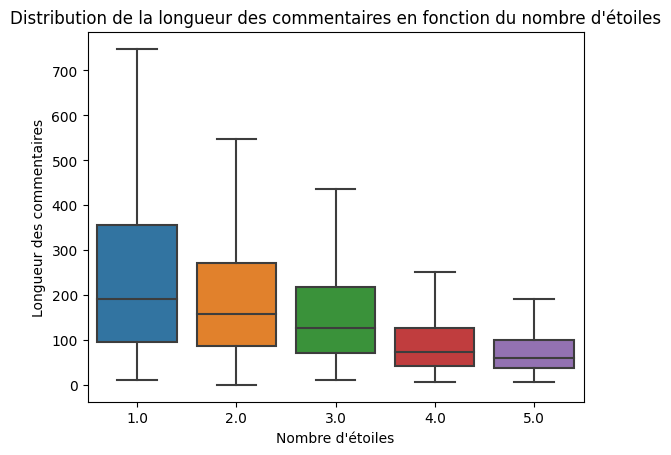

In [ ]:
# Distribution de la longueur des commentaires en fonction du nombre d'étoiles

sns.boxplot(x='star', y='longueur', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Longueur des commentaires")
plt.title("Distribution de la longueur des commentaires en fonction du nombre d'étoiles")
plt.show();

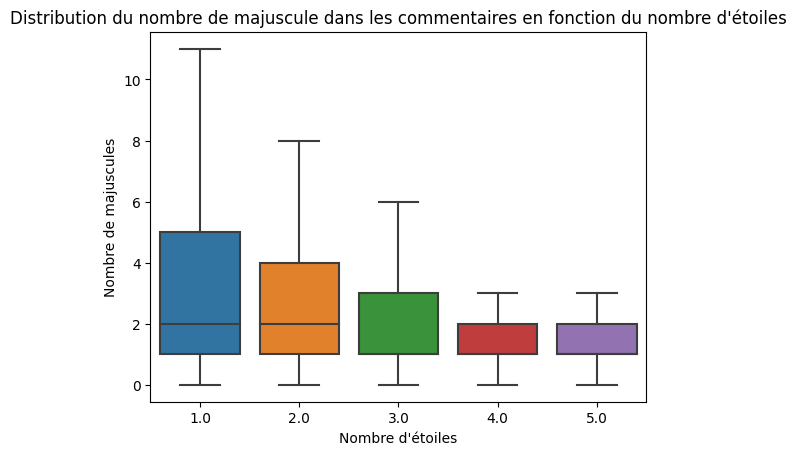

In [ ]:
# Distribution du nombre de majuscule dans les commentaires en fonction du nombre d'étoiles

sns.boxplot(x='star', y='majuscule', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre de majuscules")
plt.title("Distribution du nombre de majuscule dans les commentaires en fonction du nombre d'étoiles")
plt.show();

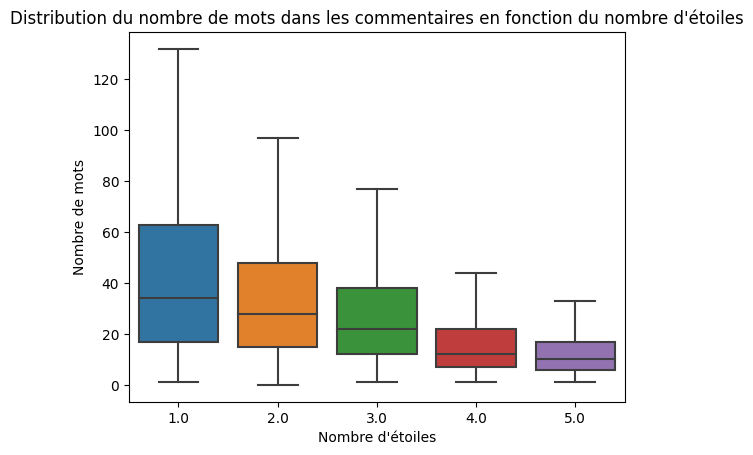

In [ ]:
# Distribution du nombre de mots dans les commentaires en fonction du nombre d'étoiles

sns.boxplot(x='star', y='nb_mots', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre de mots")
plt.title("Distribution du nombre de mots dans les commentaires en fonction du nombre d'étoiles")
plt.show();

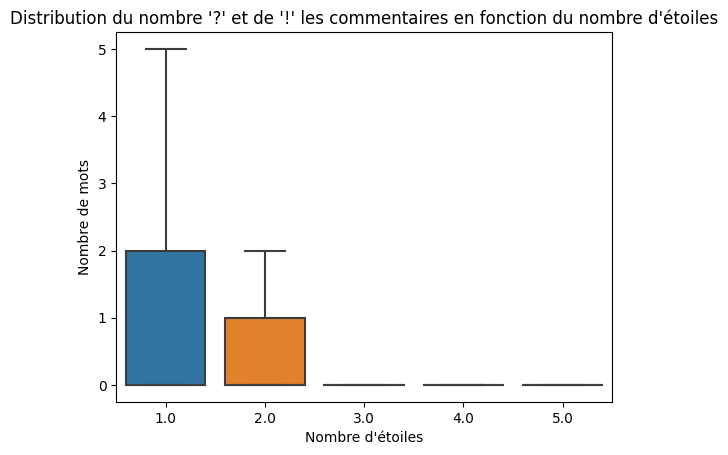

In [ ]:
# Distribution du nombre '?' et de '!' les commentaires en fonction du nombre d'étoiles

sns.boxplot(x='star', y='ponct', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre de mots")
plt.title("Distribution du nombre '?' et de '!' les commentaires en fonction du nombre d'étoiles")
plt.show();

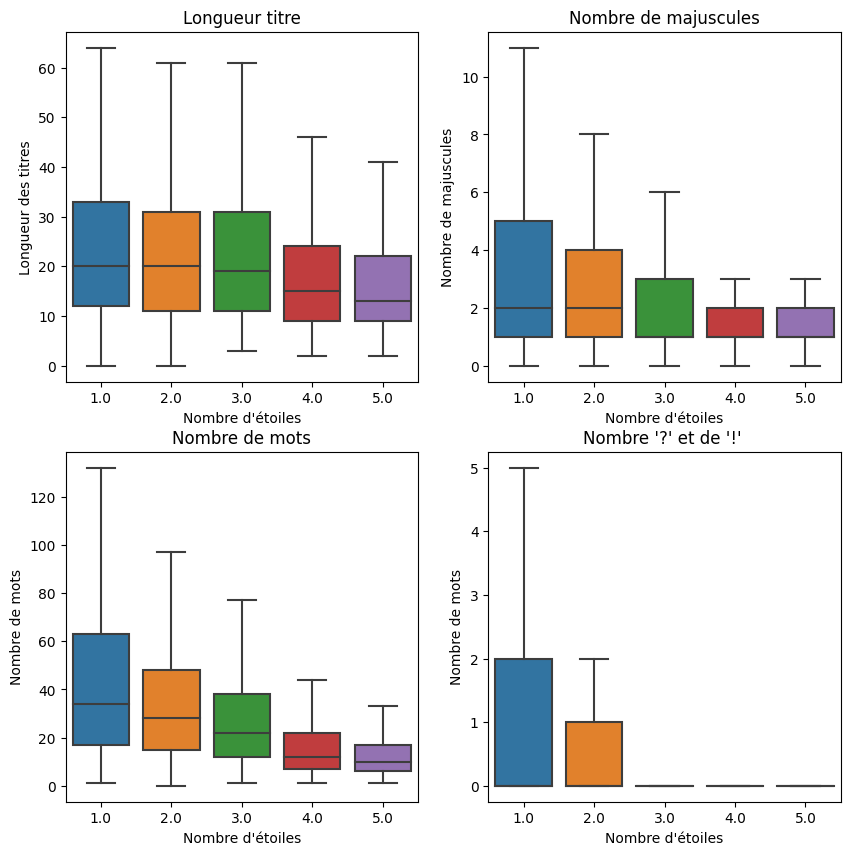

In [ ]:
# Graphique synthétique des 4 analyses précédentes :
fig= plt.figure(figsize=(10,10))

plt.subplot(221)
sns.boxplot(x='star', y='longueur_titre', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Longueur des titres")
plt.title("Longueur titre")

plt.subplot(222)
sns.boxplot(x='star', y='majuscule', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre de majuscules")
plt.title("Nombre de majuscules")

plt.subplot(223)
sns.boxplot(x='star', y='nb_mots', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre de mots")
plt.title("Nombre de mots")

plt.subplot(224)
sns.boxplot(x='star', y='ponct', data=df, showfliers=False)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre de mots")
plt.title("Nombre '?' et de '!' ");

##Etude des correlations

In [ ]:
# Etude de la correlation des métadonnées

df_pair=df.drop(["client","date_commande","date","Commentaire","pays","Titre","ngram_2","ngram_3","ngram_2_titre","ngram_3_titre"],axis=1)
g=sns.PairGrid(df_pair, hue='star')
g.map(plt.scatter, alpha=0.6)
g.add_legend()

KeyboardInterrupt: ignored

In [ ]:
df.corr()

In [ ]:
df[["star","longueur_titre", "majuscule_titre", "ponct_titre", "nb_mots_titre"]].corr()

#**Modélisation**

## KNN plus proches *voisins*

### Préparation des données

In [ ]:
# Pour associer l'environnement avec Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Drive non connecté")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/data_preparee2.csv', index_col=0)
df.head()

client  star      date_commande        date  nbr_avis  \
0             Agani   1.0     : 26 août 2022  2023-02-27       2.0   
1  CHANTAL SLATKINE   1.0  : 26 février 2023  2023-02-27       2.0   
2               LDC   1.0  : 26 février 2023  2023-02-27       2.0   
3      anass jeffal   1.0  : 27 octobre 2022  2023-02-27       1.0   
4          aurélien   1.0  : 27 février 2023  2023-02-27       1.0   

                                         Commentaire pays  \
0  ['jamais', 'reçu', 'commande', 'écris', 'showr...   FR   
1  ['commandé', 'collier', 'lun', 'ok', 'lautre',...   FR   
2  ['commandé', 'airpods', 'reconditionnés', 'dit...   FR   
3  ['produit', 'acheté', 'septembre', 'retourné',...   FR   
4  ['encore', 'commande', 'partiellement', 'annul...   FR   

                                       Titre  longueur  majuscule  ...  \
0             ['jamais', 'reçu', 'commande']       427          7  ...   
1                    ['commandé', 'collier']       537         13  ...   
2  ['très', 'déçue', 'dernière', 'commande']       563          8  ...   
3         ['produit', 'acheté', 'septembre']       612          6  ...   
4                     ['encore', 'commande']       405          2  ...   

   ngrams_3_titre('tres', 'bon', 'site').1  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   ngrams_3_titre('bon', 'traitement', 'commande').1  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

  ngrams_3_titre('tout', 'très', 'bien').1  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

  ngrams_3_titre('peut', 'mieux', 'faire').1  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   ngrams_3_titre('très', 'bon', 'service').1  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   ngrams_3_titre('livraison', 'peu', 'long').1  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   ngrams_3_titre('livraison', 'non', 'respecté').1  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   ngrams_3_titre('délai', 'trop', 'long').1  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

  ngrams_3_titre('très', 'bonne', 'qualité').1  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

  ngrams_3_titre('produit', 'non', 'conforme').1  
0                         

In [ ]:
display(df.describe())
display(df.info())
display(df.isna().sum())

star       nbr_avis       longueur      majuscule  \
count  168896.000000  168895.000000  168897.000000  168897.000000   
mean        3.591465       2.193854     138.320716       2.898731   
std         1.371037       2.487243     168.537417      11.032641   
min         1.000000       0.000000       0.000000       0.000000   
25%         3.000000       1.000000      47.000000       1.000000   
50%         4.000000       1.000000      87.000000       1.000000   
75%         5.000000       2.000000     167.000000       2.000000   
max         5.000000     162.000000    5498.000000     913.000000   

               ponct        nb_mots  longueur_titre  majuscule_titre  \
count  168897.000000  168897.000000   168897.000000    168897.000000   
mean        0.503028      24.032647       20.332872         1.171199   
std         1.791893      29.601382       16.038658         3.059387   
min         0.000000       0.000000        0.000000         0.000000   
25%         0.000000       8.000000        9.000000         0.000000   
50%         0.000000      15.000000       16.000000         1.000000   
75%         0.000000      29.000000       27.000000         1.000000   
max       154.000000     963.000000      200.000000       130.000000   

         ponct_titre  nb_mots_titre  ...  \
count  168897.000000  168897.000000  ...   
mean        0.120269       3.343949  ...   
std         0.628566       2.814516  ...   
min         0.000000       0.000000  ...   
25%         0.000000       1.000000  ...   
50%         0.000000       2.000000  ...   
75%         0.000000       4.000000  ...   
max        63.000000      43.000000  ...   

       ngrams_3_titre('tres', 'bon', 'site').1  \
count                            168897.000000   
mean                                  0.001593   
std                                   0.039877   
min                                   0.000000   
25%                                   0.000000   
50%                                   0.000000   
75%                                   0.000000   
max                                   1.000000   

       ngrams_3_titre('bon', 'traitement', 'commande').1  \
count                                      168897.000000   
mean                                            0.001551   
std                                             0.039355   
min                                             0.000000   
25%                                             0.000000   
50%                                             0.000000   
75%                                             0.000000   
max                                             1.000000   

       ngrams_3_titre('tout', 'très', 'bien').1  \
count                             168897.000000   
mean                                   0.001516   
std                                    0.038903   
min                                    0.000000   
25%                                    0.000000   
50%                                    0.000000   
75%                                    0.000000   
max                                    1.000000   

       ngrams_3_titre('peut', 'mieux', 'faire').1  \
count                               168897.000000   
mean                                     0.001510   
std                                      0.038827   
min                                      0.000000   
25%                                      0.000000   
50%                                      0.000000   
75%                                      0.000000   
max                                      1.000000   

       ngrams_3_titre('très', 'bon', 'service').1  \
count                               168897.000000   
mean                                     0.001303   
std                                      0.036068   
min                                      0.000000   
25%                                      0.000000   
50%                                      0.000000   
75%                                      0.0000

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168897 entries, 0 to 168896
Columns: 221 entries, client to ngrams_3_titre('produit', 'non', 'conforme').1
dtypes: float64(2), int64(209), object(10)
memory usage: 286.1+ MB


None

client                                              1
star                                                1
date_commande                                       1
date                                                1
nbr_avis                                            2
                                                   ..
ngrams_3_titre('livraison', 'peu', 'long').1        0
ngrams_3_titre('livraison', 'non', 'respecté').1    0
ngrams_3_titre('délai', 'trop', 'long').1           0
ngrams_3_titre('très', 'bonne', 'qualité').1        0
ngrams_3_titre('produit', 'non', 'conforme').1      0
Length: 221, dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
# supprimer les varibales non utiles : nom du client, pays, date d'achat, ...
# suppression du titre du commentaire et le texte du commentaire


In [ ]:
df.columns[:20]

Index(['client', 'star', 'date_commande', 'date', 'nbr_avis', 'Commentaire',
       'pays', 'Titre', 'longueur', 'majuscule', 'ponct', 'nb_mots', 'ngram_2',
       'ngram_3', 'longueur_titre', 'majuscule_titre', 'ponct_titre',
       'nb_mots_titre', 'ngram_2_titre', 'ngram_3_titre'],
      dtype='object')

In [ ]:
# préparation des variables descriptives et la variable cible

y = df['star']

X = df[['nbr_avis', 'longueur', 'majuscule', 'ponct', 'nb_mots',
       'longueur_titre', 'majuscule_titre', 'ponct_titre', 'nb_mots_titre']]



In [ ]:
X

nbr_avis  longueur  majuscule  ponct  nb_mots  longueur_titre  \
0            2.0       427          7      3       75              31   
1            2.0       537         13      5       90              24   
2            2.0       563          8      0      101              35   
3            1.0       612          6      0      109              33   
4            1.0       405          2      0       68              34   
...          ...       ...        ...    ...      ...             ...   
168892       1.0        33          1      0        6              10   
168893       1.0        58          2      0       11              24   
168894       1.0       132          1      0       23              44   
168895       1.0       338          0      4       58              14   
168896       5.0        72          0      0       15              26   

        majuscule_titre  ponct_titre  nb_mots_titre  
0                     1            0              6  
1                     1            0              4  
2                     1            0              6  
3                     2            0              5  
4                     0            0              4  
...                 ...          ...            ...  
168892                0            0              1  
168893                0            0              4  
168894                1            0              7  
168895                0            0              2  
168896                0            0              4  

[168892 rows x 9 columns]

In [ ]:
## Séparation des ensembles train et test des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
## Chercher les meilleurs paramètres KNN en nombre de voisins et en métrique de calcul de distance
start = time.time()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

score_minko =[]
for i in range(1, 30):
    knn = KNeighborsClassifier( n_neighbors=i, metric='minkowski')
    knn.fit(X_train, y_train)
    score_minko.append( knn.score(X_test, y_test) )

In [ ]:
score_man =[]
for i in range(1, 30):
    knn = KNeighborsClassifier( n_neighbors=i, metric='manhattan')
    knn.fit(X_train, y_train)
    score_man.append( knn.score(X_test, y_test) )

In [ ]:
score_cheb =[]
for i in range(1, 30):
    knn = KNeighborsClassifier( n_neighbors=i, metric='chebyshev')
    knn.fit(X_train, y_train)
    score_cheb.append( knn.score(X_test, y_test) );

In [ ]:
end = time.time()

print(" temps de calcul est :", round((end-start)/60,2), "minutes")

 temps de calcul est : 5.47 minutes


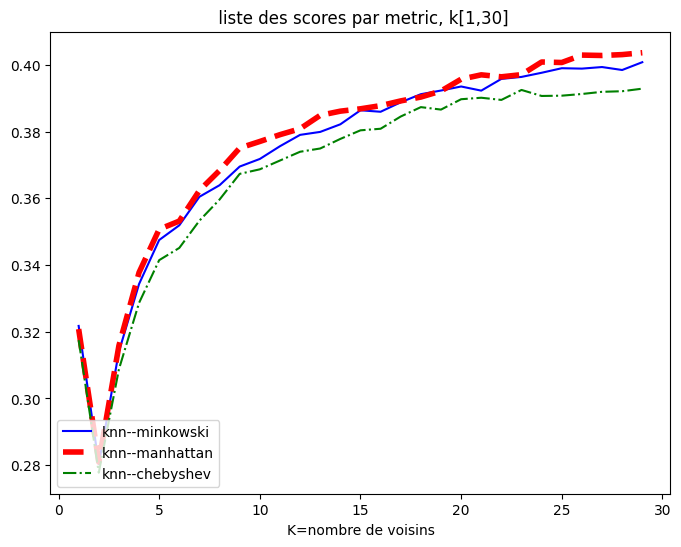

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(range(1, 30), score_minko, 'b-', label='knn--minkowski')

plt.plot(range(1, 30), score_man, 'r--', linewidth=4, label='knn--manhattan')

plt.plot(range(1, 30), score_cheb, color= 'green', linestyle='-.', label='knn--chebyshev' )

plt.title(' liste des scores par metric, k[1,30]')

plt.xlabel('K=nombre de voisins')
plt.ylabel('')

plt.legend(loc='lower left');

In [ ]:
knn_10 = KNeighborsClassifier( n_neighbors=10, metric='manhattan')
knn_10.fit(X_train, y_train)
y_pred_knn10 = knn_10.predict(X_test)
print(confusion_matrix(y_test, y_pred_knn10))

[[1423  378 1092  780  673]
 [ 701  298  891  619  562]
 [ 928  499 1830 1433 1311]
 [ 580  323 1526 2934 3524]
 [ 459  258 1399 3107 6251]]


In [ ]:
print(classification_report(y_pred_knn10, y_test))

              precision    recall  f1-score   support

         1.0       0.33      0.35      0.34      4091
         2.0       0.10      0.17      0.12      1756
         3.0       0.30      0.27      0.29      6738
         4.0       0.33      0.33      0.33      8873
         5.0       0.54      0.51      0.53     12321

    accuracy                           0.38     33779
   macro avg       0.32      0.33      0.32     33779
weighted avg       0.39      0.38      0.38     33779



### Standardisation des données

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

array([[-0.07838385, -0.65890714, -0.17064172, ..., -0.05655125,
        -0.19496127, -0.47877326],
       [-0.47898442, -0.62334549, -0.17064172, ...,  0.92450708,
        -0.19496127, -0.12369317],
       [-0.47898442,  0.02269116, -0.08123439, ..., -0.05655125,
        -0.19496127,  0.58646702],
       ...,
       [-0.47898442,  1.58740378,  0.09758027, ..., -0.3835707 ,
        -0.19496127,  1.6517073 ],
       [-0.07838385,  1.76521203,  0.27639492, ...,  0.27046819,
        -0.19496127, -0.47877326],
       [-0.47898442,  1.95487416,  0.36580225, ..., -0.05655125,
        -0.19496127,  0.94154711]])

In [ ]:
score_man =[]
for i in range(1, 30):
    knn = KNeighborsClassifier( n_neighbors=i, metric='manhattan')
    knn.fit(X_train, y_train)
    score_man.append( knn.score(X_test, y_test) )

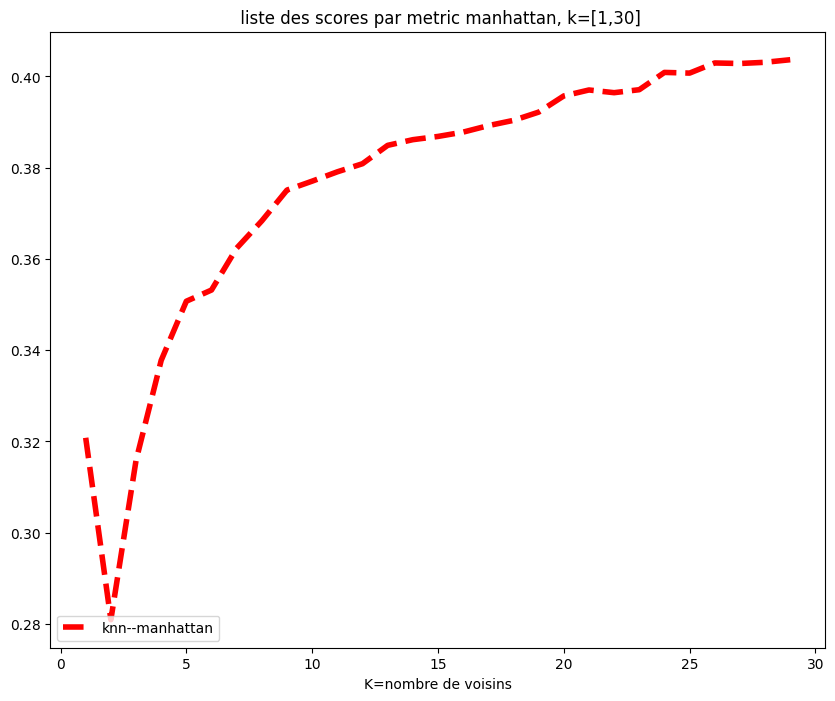

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.plot(range(1, 30), score_man, 'r--', linewidth=4, label='knn--manhattan')

plt.title(' liste des scores par metric manhattan, k=[1,30]')

plt.xlabel('K=nombre de voisins')
plt.ylabel('')

plt.legend(loc='lower left');

### Etape 1 : réduction de dimensions par features selection à variance nulles

In [ ]:
sel = VarianceThreshold(threshold=1e-06)
sel.fit(X_train)

VarianceThreshold(threshold=1e-06)

In [ ]:
mask = sel.get_support()

plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Feature selection');

NameError: ignored

In [ ]:
X_train_save = X_train
X_test_save = X_test

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

In [ ]:
X_train.shape

(135113, 9)

In [ ]:
X_test

array([[  2.,  27.,   1., ...,   1.,   0.,   2.],
       [  1.,  33.,   1., ...,   4.,   0.,   3.],
       [  1., 142.,   2., ...,   1.,   0.,   5.],
       ...,
       [  1., 406.,   4., ...,   0.,   0.,   8.],
       [  2., 436.,   6., ...,   2.,   0.,   2.],
       [  1., 468.,   7., ...,   1.,   0.,   6.]])

In [ ]:
score_man =[]
for i in range(1, 30):
    knn = KNeighborsClassifier( n_neighbors=i, metric='manhattan')
    knn.fit(X_train, y_train)
    score_man.append( knn.score(X_test, y_test) )

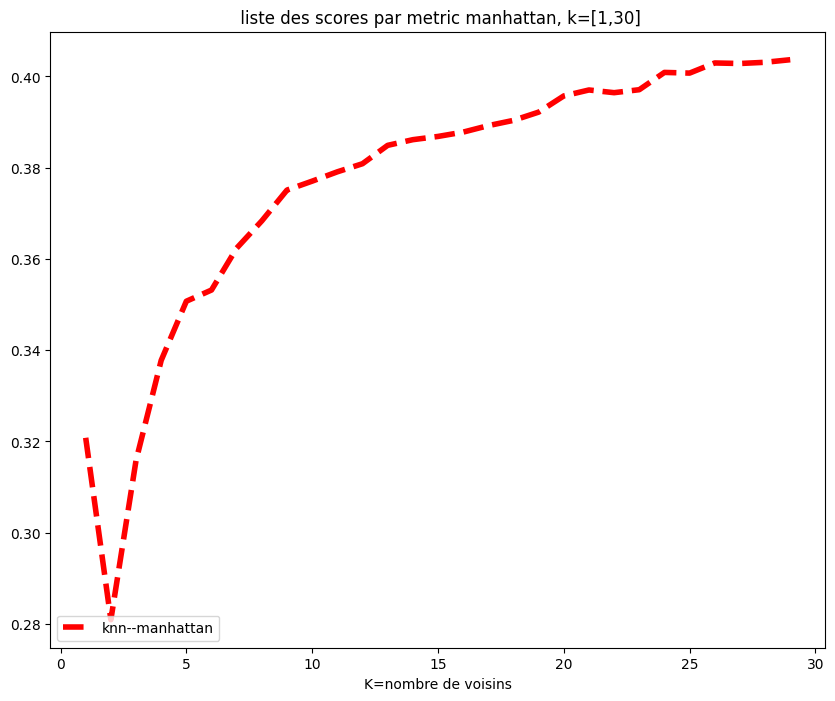

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.plot(range(1, 30), score_man, 'r--', linewidth=4, label='knn--manhattan')

plt.title(' liste des scores par metric manhattan, k=[1,30]')

plt.xlabel('K=nombre de voisins')
plt.ylabel('')

plt.legend(loc='lower left');

Selection des 5 variables les plus corrélées à la variable cible

### Etape 2 : selction des variables avec SelectKBest, 5 meilleures variables

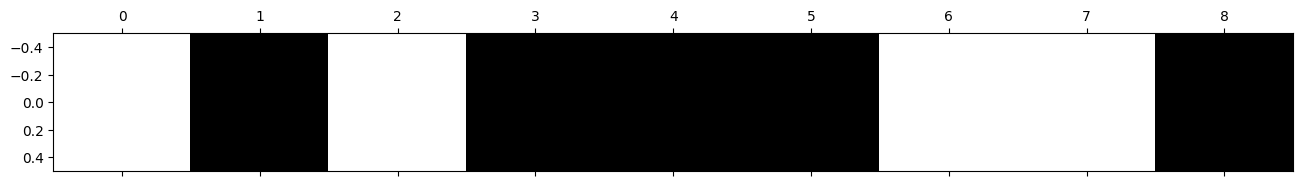

In [ ]:
X_train = X_train_save
X_test = X_test_save


sel = SelectKBest(score_func=f_regression, k=5)
sel.fit(X_train, y_train)
mask = sel.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [ ]:

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

In [ ]:
score_man =[]
for i in range(1, 30):
    knn = KNeighborsClassifier( n_neighbors=i, metric='manhattan')
    knn.fit(X_train, y_train)
    score_man.append( knn.score(X_test, y_test) )

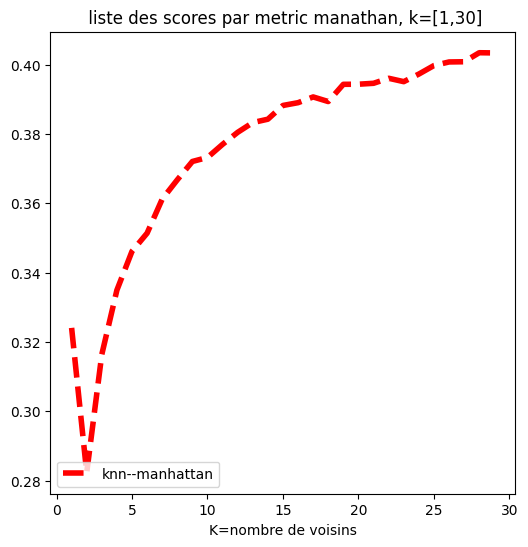

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

plt.plot(range(1, 30), score_man, 'r--', linewidth=4, label='knn--manhattan')

plt.title(' liste des scores par metric manathan, k=[1,30]')

plt.xlabel('K=nombre de voisins')
plt.ylabel('')

plt.legend(loc='lower left');

In [ ]:
knn = KNeighborsClassifier( n_neighbors=10, metric='manhattan')
knn.fit(X_train, y_train)
y_pred_knn10 = knn.predict(X_test)
print(classification_report( y_pred_knn10, y_test) )



print(confusion_matrix(y_test, y_pred_knn10))

              precision    recall  f1-score   support

         1.0       0.32      0.34      0.33      4099
         2.0       0.08      0.15      0.11      1661
         3.0       0.28      0.26      0.27      6320
         4.0       0.32      0.33      0.32      8480
         5.0       0.56      0.49      0.52     13219

    accuracy                           0.37     33779
   macro avg       0.31      0.32      0.31     33779
weighted avg       0.40      0.37      0.38     33779

[[1407  350 1037  736  816]
 [ 680  249  890  608  644]
 [ 947  469 1659 1397 1529]
 [ 579  333 1407 2815 3753]
 [ 486  260 1327 2924 6477]]


##Les modèles effectués avec un Bag of Word

> ### RandomForest 1 : Commentaires, titres, et métadonnées


In [ ]:
# Nécessite l'execution de la section Transformation des données

# ou importation des données transformées
try:
  df = pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/data_preparee2.csv', index_col=[0]) #ligne pour récupérer les données sur G-Drive
except:
  df = pd.read_csv('data_preparee2.csv', index_col=[0])

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


Nombre de composantes retenues : 30


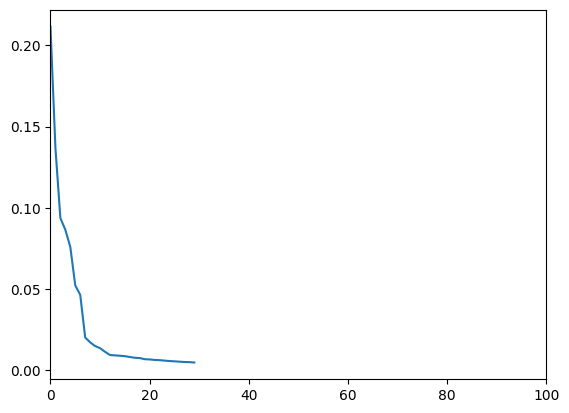

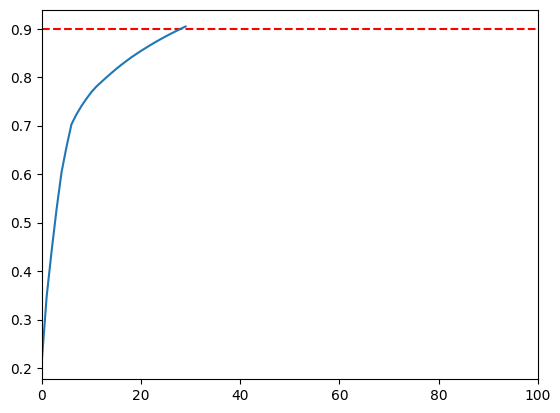

In [ ]:
# Drop des colonnes que l'on ne conserve pas pour la modélisation
df=df.dropna(axis=0,how='any')
df=df.drop(columns=['client', 'star', 'date_commande', 'date', 'pays', 'Commentaire', 'Titre', 'ngram_2', 'ngram_3', 'ngram_2_titre', 'ngram_3_titre'], axis=1)

# Préparation de la variable cible et des variables explicatives
y=df['star_cluster']
X=df.drop('star_cluster',1)


# Etape Centrer Réduire des variables continues
variables_continues=['nbr_avis', 'longueur', 'majuscule', 'ponct', 'nb_mots',
       'longueur_titre', 'majuscule_titre', 'ponct_titre', 'nb_mots_titre']
scaler = StandardScaler()
X.loc[:, variables_continues] = scaler.fit_transform(X.loc[:, variables_continues])

# Séparation en un ensemble d'entrainement, et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

# Réduction de la dimension via PCA

pca = PCA(n_components = 0.9)
pca.fit(X)
print("Nombre de composantes retenues :", pca.n_components_)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Etude de la PCA
plt.figure()
plt.xlim(0,100)
plt.plot(pca.explained_variance_ratio_);

plt.figure()
plt.xlim(0,100)
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());

In [ ]:
# RandomForest
RFC = RandomForestClassifier(n_jobs = -1)
RFC.fit(X_train_pca, y_train)
score_rfc=RFC.score(X_test_pca, y_test)
print(score_rfc)

y_pred=RFC.predict(X_test_pca)
print(classification_report(y_test, y_pred))

0.8067438349270256
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     13496
           1       0.84      0.84      0.84     20283

    accuracy                           0.81     33779
   macro avg       0.80      0.80      0.80     33779
weighted avg       0.81      0.81      0.81     33779



In [ ]:
# Test over_sampling
rOs = RandomOverSampler()
X_train_pca_ovs, y_train_ovs = rOs.fit_resample(X_train_pca, y_train)
print('Classes échantillons oversampled :', dict(pd.Series(y_train_ovs).value_counts()))

# RandomForest avec oversampling
RFC = RandomForestClassifier(n_jobs = -1)
RFC.fit(X_train_pca_ovs, y_train_ovs)
score_rfc=RFC.score(X_test_pca, y_test)
print(score_rfc)

y_pred=RFC.predict(X_test_pca)
print(classification_report(y_test, y_pred))

# L'oversampling n'est pas très conclusif

Classes échantillons oversampled : {0: 80953, 1: 80953}
0.8054412504810681
              precision    recall  f1-score   support

           0       0.75      0.78      0.76     13496
           1       0.85      0.82      0.84     20283

    accuracy                           0.81     33779
   macro avg       0.80      0.80      0.80     33779
weighted avg       0.81      0.81      0.81     33779



(-1.0, 1.0)

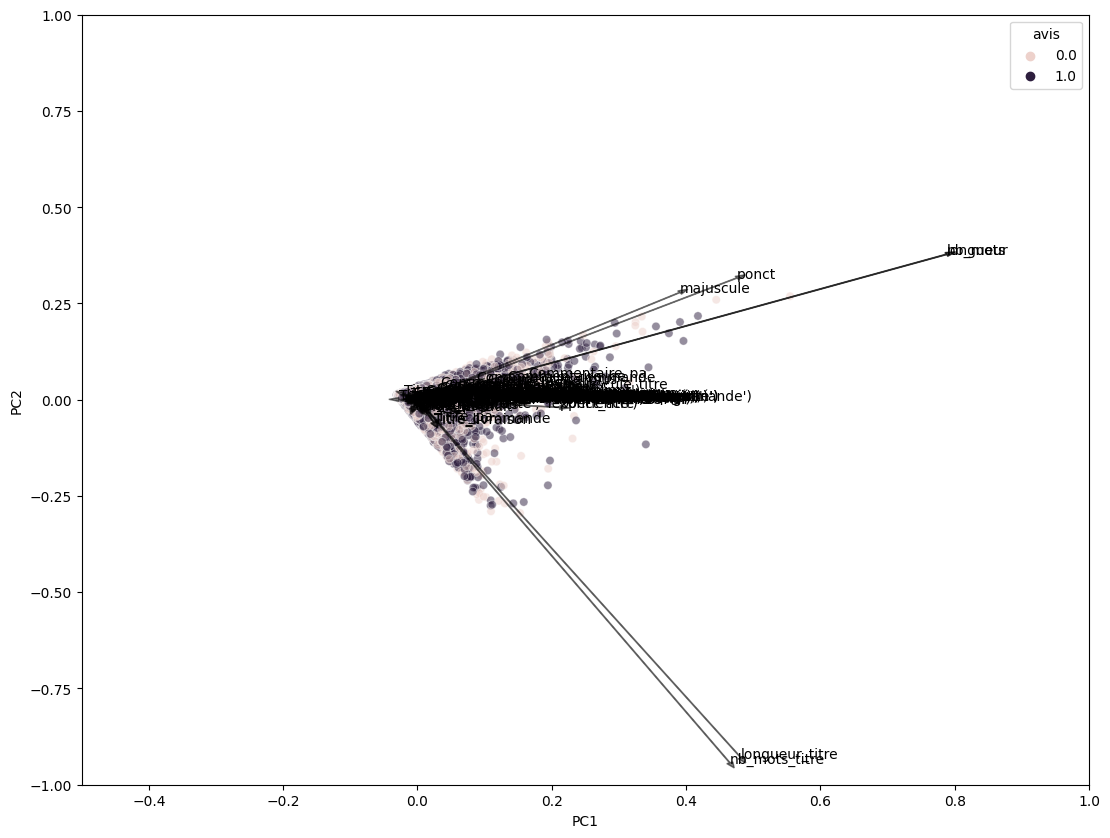

In [ ]:
# Visualisation du poids des composantes principales

n = X_train.shape[1]

coeff = pca.components_.transpose()
xs = X_train_pca[:, 0]
ys = X_train_pca[:, 1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())

principalDf = pd.DataFrame({'PC1': xs*scalex, 'PC2': ys * scaley})

y_train_pred=RFC.predict(X_test_pca)
finalDF = pd.concat([principalDf, pd.Series(
    y_train_pred, name='avis')], axis=1)

plt.figure(figsize=(13, 10))

sns.scatterplot(x='PC1', y='PC2', hue='avis', data=finalDF, alpha=0.5)

for i in range(n):
    plt.arrow(0, 0, coeff[i, 0]*1.5, coeff[i, 1]*1.5,
              color='k', alpha=0.5, head_width=0.01, )
    plt.text(coeff[i, 0]*1.5, coeff[i, 1] * 1.5, X_train.columns[i], color='k')

plt.xlim(-0.5, 1)
plt.ylim(-1, 1)



> ### RandomForest 2 : Commentaires et métadonnées



In [ ]:
# Nécessite l'execution de la section Transformation des données

# ou importation des données transformées
try:
  df = pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/data_preparee2.csv', index_col=[0]) #ligne pour récupérer les données sur G-Drive
except:
  df = pd.read_csv('data_preparee2.csv', index_col=[0])

In [ ]:
# Drop des colonnes que l'on ne conserve pas pour la modélisation

df=df.dropna(axis=0,how='any')
df=df.drop(columns=['client', 'star', 'date_commande', 'date', 'pays', 'Commentaire', 'Titre', 'ngram_2', 'ngram_3', 'ngram_2_titre', 'ngram_3_titre'], axis=1)

# Préparation de la variable cible et des variables explicatives
y=df['star_cluster']
X=df.drop('star_cluster',1)

# Etape Centrer Réduire des variables continues
variables_continues=['nbr_avis', 'longueur', 'majuscule', 'ponct', 'nb_mots']
scaler = StandardScaler()
X.loc[:, variables_continues] = scaler.fit_transform(X.loc[:, variables_continues])

# Séparation en un ensemble d'entrainement, et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)



In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [ ]:
# RandomForest
RFC = RandomForestClassifier(n_jobs = -1)
RFC.fit(X_train, y_train)
score_rfc=RFC.score(X_test, y_test)
print(score_rfc)

y_pred=RFC.predict(X_test)
print(classification_report(y_test, y_pred))

0.8310192723289618
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     13496
           1       0.86      0.86      0.86     20283

    accuracy                           0.83     33779
   macro avg       0.82      0.82      0.82     33779
weighted avg       0.83      0.83      0.83     33779



##Bag of Words avec n-grams, sans métadonnées

In [ ]:
# Nécessite l'execution de la section Transformation des données

# ou importation des données transformées
try:
  df = pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/data_preparee2.csv', index_col=[0]) #ligne pour récupérer les données sur G-Drive
except:
  df = pd.read_csv('data_preparee2.csv', index_col=[0])

In [ ]:
# Transformation des données
df=df.dropna(axis=0,how='any')
df=df.rename(columns={"Commentaire":"Text"})
df['Text'] = df['Text'].apply(lambda x: ' '.join(re.findall(r"'(\w+)'", x)))

# Compilation positives/négatives selon les notes
df['Sentiment'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)

df=df[["Text","Sentiment"]]
df["Text"].fillna('', inplace=True)

# Séparation de la variable explicative de la variable à prédire
X, y = df.Text, df.Sentiment

# Séparation du jeu de données en données d'entraînement et données test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Réduction de la taille de l'échantillon
sample_size = int(0.5 * len(X_train)) #0.5 car 50% de la taille initiale
X_train = X_train.sample(n=sample_size, random_state=42)
y_train = y_train.loc[X_train.index]

# Initialisation de l'objet vectorizer
vectorizer = CountVectorizer()

# Mise à jour de la valeur de X_train et X_test
X_train = vectorizer.fit_transform(X_train).todense()
X_test = vectorizer.transform(X_test).todense()

# Création du classificateur XGBoost
clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.5,
    max_depth=3,
    n_jobs=-1,
    tree_method='gpu_hist'
    )

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Calcul et affichage de classification_report
print( classification_report(y_test, y_pred) )

# Calcul et affichage de la matrice de confusion
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       0.84      0.77      0.80     20276
           1       0.85      0.90      0.88     30392

    accuracy                           0.85     50668
   macro avg       0.85      0.84      0.84     50668
weighted avg       0.85      0.85      0.85     50668



Classe prédite      0      1
Classe réelle               
0               15594   4682
1                2946  27446

##Bag of Words avec plusieurs n-gram

### Chargement des données

In [ ]:
# Pour associer l'environnement avec Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Drive non connecté")

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/data_preparee2.csv', index_col=0)
df.head()

client  star      date_commande        date  nbr_avis  \
0             Agani   1.0     : 26 août 2022  2023-02-27       2.0   
1  CHANTAL SLATKINE   1.0  : 26 février 2023  2023-02-27       2.0   
2               LDC   1.0  : 26 février 2023  2023-02-27       2.0   
3      anass jeffal   1.0  : 27 octobre 2022  2023-02-27       1.0   
4          aurélien   1.0  : 27 février 2023  2023-02-27       1.0   

                                         Commentaire pays  \
0  ['jamais', 'reçu', 'commande', 'écris', 'showr...   FR   
1  ['commandé', 'collier', 'lun', 'ok', 'lautre',...   FR   
2  ['commandé', 'airpods', 'reconditionnés', 'dit...   FR   
3  ['produit', 'acheté', 'septembre', 'retourné',...   FR   
4  ['encore', 'commande', 'partiellement', 'annul...   FR   

                                       Titre  longueur  majuscule  ...  \
0             ['jamais', 'reçu', 'commande']       427          7  ...   
1                    ['commandé', 'collier']       537         13  ...   
2  ['très', 'déçue', 'dernière', 'commande']       563          8  ...   
3         ['produit', 'acheté', 'septembre']       612          6  ...   
4                     ['encore', 'commande']       405          2  ...   

   ngrams_3_titre('tres', 'bon', 'site').1  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   ngrams_3_titre('bon', 'traitement', 'commande').1  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

  ngrams_3_titre('tout', 'très', 'bien').1  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

  ngrams_3_titre('peut', 'mieux', 'faire').1  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   ngrams_3_titre('très', 'bon', 'service').1  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   ngrams_3_titre('livraison', 'peu', 'long').1  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   ngrams_3_titre('livraison', 'non', 'respecté').1  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   ngrams_3_titre('délai', 'trop', 'long').1  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

  ngrams_3_titre('très', 'bonne', 'qualité').1  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

  ngrams_3_titre('produit', 'non', 'conforme').1  
0                         

In [ ]:
df['star'].unique()

array([ 1.,  5.,  3.,  4.,  2., nan])

In [ ]:
df.dropna(inplace=True)
print(df.isna().sum())


client                                              0
star                                                0
date_commande                                       0
date                                                0
nbr_avis                                            0
                                                   ..
ngrams_3_titre('livraison', 'peu', 'long').1        0
ngrams_3_titre('livraison', 'non', 'respecté').1    0
ngrams_3_titre('délai', 'trop', 'long').1           0
ngrams_3_titre('très', 'bonne', 'qualité').1        0
ngrams_3_titre('produit', 'non', 'conforme').1      0
Length: 221, dtype: int64


### Choix des classes (0, 1) = ( négatif, positif) à attribuer aux notes 0, 1, 2, 3, 4, 5

#### Application d'un modèle Randomforest de classification sur les notes ( 1,2,3,4,5)


In [ ]:
## Application d'un modèle de classification randomforest sur les notes ( 1,2,3,4,5)

X = df.Commentaire

y = df.star

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french') )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()
t0 = time.time()

# Entrainer un modèle de Random Forest
rf = RandomForestClassifier(n_jobs=-1)
# Entraînement du modèle.
rf.fit(X_train, y_train)
t1 = time.time()

print('le temps de calcul du randomforest classification est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print('le score en randomforest pour les notes (1,2,3,4,5) est :', round(rf.score(X_test, y_test),2))
print()

# Affichage d'un rapport de classification
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

print()
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print()
confusion_matrix


Vocabulary size:  4000
{'chaussures': 503, 'très': 3744, 'mauvaises': 2211, 'qualité': 2963, 'elles': 1264, 'trop': 3730, 'rapidement': 3021, 'livraison': 2049, 'temp': 3623, 'emballage': 1266, 'nickel': 2394, 'marchandises': 2178, 'conformes': 686, 'parfait': 2543, 'recommande': 3060, 'achats': 37, 'retours': 3213, 'faciles': 1425, 'produits': 2840, 'parfois': 2547}

le temps de calcul du randomforest classification est :  10.5 minutes

le score en randomforest pour les notes (1,2,3,4,5) est : 0.55

              precision    recall  f1-score   support

         1.0       0.53      0.62      0.57      4363
         2.0       0.31      0.06      0.10      3114
         3.0       0.44      0.47      0.46      6039
         4.0       0.49      0.44      0.46      8697
         5.0       0.65      0.77      0.70     11566

    accuracy                           0.55     33779
   macro avg       0.48      0.47      0.46     33779
weighted avg       0.52      0.55      0.53     33779





Classe prédite   1.0  2.0   3.0   4.0   5.0
Classe réelle                              
1.0             2726  198   924   219   296
2.0             1126  197  1247   282   262
3.0              956  184  2855  1337   707
4.0              209   44  1111  3820  3513
5.0              125   18   341  2203  8879

In [ ]:
X_train.shape

(135113, 4000)

#### Application du modèle RandomForest sur les notes (-1, 0, +1)
pour signifier respectivement, négatif(1* ,2* ), neutre(3* ) et positif(4* ,5* )

In [ ]:
## Application du modèle RandomForest sur les notes (-1, 0, +1)
## pour signifier respectivement, négatif(1*,2*), neutre(3*) et positif(4*,5*)

X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [-1,-1,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french') )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))
print()

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})

t0 = time.time()

# Entrainer un modèle de Random Forest
rf = RandomForestClassifier(n_jobs=-1)
# Entraînement du modèle.
rf.fit(X_train, y_train)
t1 = time.time()

print('le temps de calcul du randomforest classification, notes(-1, 0, +1) est : ', round((t1-t0)/60, 2), 'minutes')
print()
print('le score en randomforest est :', round(rf.score(X_test, y_test),2))
print()
# Affichage d'un rapport de classification
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

print()
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print()
confusion_matrix


Vocabulary size:  4000

{'chaussures': 503, 'très': 3744, 'mauvaises': 2211, 'qualité': 2963, 'elles': 1264, 'trop': 3730, 'rapidement': 3021, 'livraison': 2049, 'temp': 3623, 'emballage': 1266, 'nickel': 2394, 'marchandises': 2178, 'conformes': 686, 'parfait': 2543, 'recommande': 3060, 'achats': 37, 'retours': 3213, 'faciles': 1425, 'produits': 2840, 'parfois': 2547}
le temps de calcul du randomforest classification, notes(-1, 0, +1) est :  6.75 minutes

le score en randomforest est : 0.77

              precision    recall  f1-score   support

        -1.0       0.67      0.74      0.70      7477
         0.0       0.52      0.24      0.33      6039
         1.0       0.84      0.93      0.88     20263

    accuracy                           0.77     33779
   macro avg       0.67      0.64      0.64     33779
weighted avg       0.74      0.77      0.74     33779





Classe prédite  -1.0   0.0    1.0
Classe réelle                    
-1.0            5556   686   1235
 0.0            2095  1444   2500
 1.0             695   664  18904

#### Application du modèle RandomForest sur les notes (0, 1)
pour signifier respectivement, négatif(1* ,2* ,3* ,4* ) et positif(5* )

In [ ]:
# Application du modèle RandomForest sur les notes (0, 1)
# pour signifier respectivement, négatif(1*,2*,3*,4*) et positif(5*)


X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,0,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french') )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()


t0 = time.time()

# Entrainer un modèle de Random Forest
rf = RandomForestClassifier(n_jobs=-1)
# Entraînement du modèle.
rf.fit(X_train, y_train)
t1 = time.time()


print('le temps de calcul du randomforest classification est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print('le score en randomforest est :', round(rf.score(X_test, y_test),2))
print()

# Affichage d'un rapport de classification
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

print()
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print()
confusion_matrix


Vocabulary size:  4000
{'chaussures': 503, 'très': 3744, 'mauvaises': 2211, 'qualité': 2963, 'elles': 1264, 'trop': 3730, 'rapidement': 3021, 'livraison': 2049, 'temp': 3623, 'emballage': 1266, 'nickel': 2394, 'marchandises': 2178, 'conformes': 686, 'parfait': 2543, 'recommande': 3060, 'achats': 37, 'retours': 3213, 'faciles': 1425, 'produits': 2840, 'parfois': 2547}

le temps de calcul du randomforest classification est :  7.64 minutes

le score en randomforest est : 0.79

              precision    recall  f1-score   support

         0.0       0.83      0.86      0.85     22213
         1.0       0.71      0.67      0.69     11566

    accuracy                           0.79     33779
   macro avg       0.77      0.76      0.77     33779
weighted avg       0.79      0.79      0.79     33779





Classe prédite    0.0   1.0
Classe réelle              
0.0             19118  3095
1.0              3843  7723

#### Application du modèle RandomForest sur les notes (0, 1)
pour signifier respectivement, négatif (1* ,2* ,3* ) et positif(4* ,5* )

In [ ]:
# Application du modèle RandomForest sur les notes (0, 1)
# pour signifier respectivement, négatif (1*,2*,3*) et positif(4*,5*)

X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french') )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

t0 = time.time()

# Entrainer un modèle de Random Forest
rf = RandomForestClassifier(n_jobs=-1)
# Entraînement du modèle.
rf.fit(X_train, y_train)
t1 = time.time()

print('le temps de calcul du randomforest classification est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print('le score en randomforest est :', round(rf.score(X_test, y_test),2))
print()

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print()

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print()
confusion_matrix


Vocabulary size:  4000
{'chaussures': 503, 'très': 3744, 'mauvaises': 2211, 'qualité': 2963, 'elles': 1264, 'trop': 3730, 'rapidement': 3021, 'livraison': 2049, 'temp': 3623, 'emballage': 1266, 'nickel': 2394, 'marchandises': 2178, 'conformes': 686, 'parfait': 2543, 'recommande': 3060, 'achats': 37, 'retours': 3213, 'faciles': 1425, 'produits': 2840, 'parfois': 2547}

le temps de calcul du randomforest classification est :  5.69 minutes

le score en randomforest est : 0.87

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.83     13516
         1.0       0.89      0.89      0.89     20263

    accuracy                           0.87     33779
   macro avg       0.86      0.86      0.86     33779
weighted avg       0.87      0.87      0.87     33779





Classe prédite    0.0    1.0
Classe réelle               
0.0             11173   2343
1.0              2197  18066

### Application de XGBOOST sur le ngram=1 sur les notes (0,1)

In [ ]:
X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french') )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

t0 = time.time()

xgb_clf = xgb.XGBClassifier(n_estimators=1000,learning_rate=0.01,max_depth=6,n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

t1 = time.time()


print('le temps de calcul du Xgboost en unigram est est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print('le score de xgbooost en unigram est :', round(xgb_clf.score(X_test, y_test),2))
print()

print( classification_report(y_test, y_pred) )
print()
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print()
confusion_matrix




Vocabulary size:  4000
{'chaussures': 503, 'très': 3744, 'mauvaises': 2211, 'qualité': 2963, 'elles': 1264, 'trop': 3730, 'rapidement': 3021, 'livraison': 2049, 'temp': 3623, 'emballage': 1266, 'nickel': 2394, 'marchandises': 2178, 'conformes': 686, 'parfait': 2543, 'recommande': 3060, 'achats': 37, 'retours': 3213, 'faciles': 1425, 'produits': 2840, 'parfois': 2547}

le temps de calcul du Xgboost en unigram est est :  2.91 minutes

le score de xgbooost en unigram est : 0.83

              precision    recall  f1-score   support

         0.0       0.85      0.70      0.77     13516
         1.0       0.82      0.92      0.87     20263

    accuracy                           0.83     33779
   macro avg       0.84      0.81      0.82     33779
weighted avg       0.83      0.83      0.83     33779





Classe prédite     0      1
Classe réelle              
0.0             9474   4042
1.0             1658  18605

### Application d'un Gradient boost classifier sur les notes (0,1)
pour signifier respectivement, négatif (1* ,2* ,3* ) et positif(4* ,5* )

In [ ]:
## Application d'un Gradient boost classifier sur les notes (0,1)
## pour signifier respectivement, négatif (1* ,2* ,3* ) et positif(4* ,5* )

X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french') )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

t0 = time.time()

GB_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
GB_clf.fit(X_train, y_train)
y_pred = GB_clf.predict(X_test)

t1 = time.time()

print('le temps de calcul du GradientBoost classification est : ', round((t1-t0)/60,2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print('le score du gradient boosting est :', round(GB_clf.score(X_test, y_test),2))
print()

# Affichage d'un rapport de classification

print(classification_report(y_test, y_pred))
print()
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print()
confusion_matrix


Vocabulary size:  4000
{'chaussures': 503, 'très': 3744, 'mauvaises': 2211, 'qualité': 2963, 'elles': 1264, 'trop': 3730, 'rapidement': 3021, 'livraison': 2049, 'temp': 3623, 'emballage': 1266, 'nickel': 2394, 'marchandises': 2178, 'conformes': 686, 'parfait': 2543, 'recommande': 3060, 'achats': 37, 'retours': 3213, 'faciles': 1425, 'produits': 2840, 'parfois': 2547}

le temps de calcul du GradientBoost classification est :  0.28 minutes

le score du gradient boosting est : 0.8

              precision    recall  f1-score   support

         0.0       0.84      0.62      0.71     13516
         1.0       0.78      0.92      0.85     20263

    accuracy                           0.80     33779
   macro avg       0.81      0.77      0.78     33779
weighted avg       0.81      0.80      0.79     33779





Classe prédite   0.0    1.0
Classe réelle              
0.0             8325   5191
1.0             1545  18718

### Bag of word en n-gram = 2,
Application RandomForest sur les notes (0, 1) --->  négatif (1* ,2* ,3* ) et positif(4* ,5* )

In [ ]:
# Application du modèle RandomForest sur les notes (0, 1)
# pour signifier respectivement, négatif (1*,2*,3*) et positif(4*,5*)

X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french'), ngram_range=(2,2) )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})


t0 = time.time()

# Entrainer un modèle de Random Forest
rf = RandomForestClassifier(n_jobs=-1)
# Entraînement du modèle.
rf.fit(X_train, y_train)
t1 = time.time()

print('le temps de calcul du randomforest classification en Bi-gram est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print('le score en randomforest est :', round(rf.score(X_test, y_test),2))
print()

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

Vocabulary size:  4000
{'chaussures très': 583, 'très mauvaises': 3863, 'mauvaises qualité': 2101, 'livraison temp': 1919, 'temp emballage': 3581, 'emballage nickel': 1422, 'qualité produits': 2842, 'jaime bien': 1655, 'bien site': 385, 'rapide simple': 2933, 'tout bien': 3668, 'bien passé': 362, 'satisfaite produit': 3265, 'point relais': 2560, 'relais non': 3006, 'non disponible': 2232, 'cela fait': 523, 'deux fois': 1205, 'faire livrer': 1504, 'livrer colis': 1934}
le temps de calcul du randomforest classification en Bi-gram est :  5.08 minutes

le score en randomforest est : 0.82

              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75     13516
         1.0       0.82      0.89      0.85     20263

    accuracy                           0.82     33779
   macro avg       0.82      0.80      0.80     33779
weighted avg       0.82      0.82      0.81     33779



### Bag of words en n-gram = 2,
Application d'un modèle de XGBOOOST sur les notes ( 0,1)

In [ ]:
# n-gram = 2
## Application du bag of words en n-gram = 2
## Application d'un modèle de XGBOOOST sur les notes ( 0,1)


X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french'), ngram_range=(2,2))

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

t0 = time.time()

xgb_clf = xgb.XGBClassifier(n_estimators=10000,learning_rate=0.01,max_depth=3,n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

t1 = time.time()


print('le temps de calcul du Xgboost en Bi-gram est est : ', round((t1-t0)/60, 2), 'minutes')
# Afficher l'accuracy sur le jeu de données de test.
print(' le score de xgboost classifier est :', round(xgb_clf.score(X_test, y_test),2))
print()

print( classification_report(y_test, y_pred) )

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix


Vocabulary size:  4000
{'chaussures très': 583, 'très mauvaises': 3863, 'mauvaises qualité': 2101, 'livraison temp': 1919, 'temp emballage': 3581, 'emballage nickel': 1422, 'qualité produits': 2842, 'jaime bien': 1655, 'bien site': 385, 'rapide simple': 2933, 'tout bien': 3668, 'bien passé': 362, 'satisfaite produit': 3265, 'point relais': 2560, 'relais non': 3006, 'non disponible': 2232, 'cela fait': 523, 'deux fois': 1205, 'faire livrer': 1504, 'livrer colis': 1934}

le temps de calcul du Xgboost en Bi-gram est est :  6.44 minutes
 le score de xgboost classifier est : 0.78

              precision    recall  f1-score   support

         0.0       0.86      0.55      0.67     13516
         1.0       0.76      0.94      0.84     20263

    accuracy                           0.78     33779
   macro avg       0.81      0.75      0.76     33779
weighted avg       0.80      0.78      0.77     33779



Classe prédite     0      1
Classe réelle              
0.0             7436   6080
1.0             1186  19077

### Bag of words en n-gram = 3,
Application d'un modèle de RandomForest classification sur les notes ( 1,2,3,4,5)

In [ ]:
# n-gram = 2
# Application du bag of words en n-gram = 2
# Application d'un modèle de RandomForest classification sur les notes ( 1,2,3,4,5)

X = df.Commentaire

y = df.star##

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french'), ngram_range=(3,3))

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

# appliquer un randomforest classifier
t0 = time.time()

# Entrainer un modèle de Random Forest
rf = RandomForestClassifier(n_jobs=-1)
# Entraînement du modèle.
rf.fit(X_train, y_train)
t1 = time.time()


print('le temps de calcul du randomforest classification en tri-gram est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print('le score du randomforest est :', round(rf.score(X_test, y_test),2))
print()

# Affichage d'un rapport de classification
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


Vocabulary size:  4000
{'livraison temp emballage': 1944, 'jaime bien site': 1669, 'tout bien passé': 3582, 'bien passé merci': 303, 'problème point relais': 2615, 'point relais non': 2519, 'commandés bonne qualité': 961, 'bonne qualité délais': 446, 'très contente achat': 3815, 'showroom privé jamais': 3345, 'satisfaite commande reçu': 3217, 'commande reçu colis': 842, 'délais trop long': 1428, 'trop long frais': 3664, 'long frais port': 2032, 'frais port cher': 1596, 'rien bien méchant': 3092, 'déposé point relais': 1433, 'plus dun mois': 2419, 'colis point relais': 644}

le temps de calcul du randomforest classification en tri-gram est :  5.74 minutes

le score du randomforest est : 0.42

              precision    recall  f1-score   support

         1.0       0.50      0.30      0.37      4363
         2.0       0.23      0.05      0.09      3114
         3.0       0.38      0.19      0.26      6039
         4.0       0.46      0.19      0.27      8697
         5.0       0.42     

### Bag of words en n-gram=3,
Application d'un modèle de XGBOOOST sur les notes ( 0,1)

In [ ]:
# n-gram = 2
## Application du bag of words en n-gram = 2
## Application d'un modèle de XGBOOOST sur les notes ( 0,1)


X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french'), ngram_range=(3,3) )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

t0 = time.time()

xgb_clf = xgb.XGBClassifier(n_estimators=10000,learning_rate=0.01,max_depth=3,n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

t1 = time.time()


print('le temps de calcul du Xgboost en Tri-gram est est : ', round((t1-t0)/60, 2), 'minutes')
# Afficher l'accuracy sur le jeu de données de test.
print(' le score de xgboost classifier est :', round(xgb_clf.score(X_test, y_test),2))
print()

print( classification_report(y_test, y_pred) )

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

Vocabulary size:  4000
{'livraison temp emballage': 1944, 'jaime bien site': 1669, 'tout bien passé': 3582, 'bien passé merci': 303, 'problème point relais': 2615, 'point relais non': 2519, 'commandés bonne qualité': 961, 'bonne qualité délais': 446, 'très contente achat': 3815, 'showroom privé jamais': 3345, 'satisfaite commande reçu': 3217, 'commande reçu colis': 842, 'délais trop long': 1428, 'trop long frais': 3664, 'long frais port': 2032, 'frais port cher': 1596, 'rien bien méchant': 3092, 'déposé point relais': 1433, 'plus dun mois': 2419, 'colis point relais': 644}

le temps de calcul du Xgboost en Tri-gram est est :  3.71 minutes
 le score de xgboost classifier est : 0.68

              precision    recall  f1-score   support

         0.0       0.86      0.23      0.36     13516
         1.0       0.65      0.97      0.78     20263

    accuracy                           0.68     33779
   macro avg       0.75      0.60      0.57     33779
weighted avg       0.73      0.68    

Classe prédite     0      1
Classe réelle              
0.0             3060  10456
1.0              517  19746

### Bag of words en n-gram = 1 à 2 cumulés,
Application du modèle RandomForest sur les notes (0, 1)

In [ ]:
# Application du modèle RandomForest sur les notes (0, 1)
# pour signifier respectivement, négatif (1*,2*,3*) et positif(4*,5*)

X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french'), ngram_range=(1,2) )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

t0 = time.time()

# Entrainer un modèle de Random Forest
rf = RandomForestClassifier(n_jobs=-1)
# Entraînement du modèle.
rf.fit(X_train, y_train)
t1 = time.time()

print('le temps de calcul du randomforest classification en Uni et Bi-gram est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print('le score en randomforest est :', round(rf.score(X_test, y_test),2))
print()

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print()
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

Vocabulary size:  4000
{'chaussures': 527, 'très': 3774, 'mauvaises': 2140, 'qualité': 2886, 'elles': 1310, 'trop': 3742, 'rapidement': 2966, 'chaussures très': 528, 'livraison': 1905, 'temp': 3607, 'emballage': 1312, 'nickel': 2292, 'marchandises': 2115, 'conformes': 830, 'parfait': 2408, 'livraison temp': 1974, 'recommande': 3004, 'achats': 22, 'retours': 3150, 'faciles': 1425}

le temps de calcul du randomforest classification en Uni et Bi-gram est :  6.27 minutes

le score en randomforest est : 0.87

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83     13516
         1.0       0.89      0.89      0.89     20263

    accuracy                           0.87     33779
   macro avg       0.86      0.86      0.86     33779
weighted avg       0.87      0.87      0.87     33779




Classe prédite    0.0    1.0
Classe réelle               
0.0             11271   2245
1.0              2284  17979

[texte du lien](https://)### Bag of words en n-gram = 1 à 2 cumulés,
Application d'un modèle de XGBOOOST sur les notes ( 0,1)

In [ ]:
# n-gram = 1 à 2
## Application du bag of words en n-gram = 1 à 2
## Application d'un modèle de XGBOOOST sur les notes ( 0,1)


X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french'), ngram_range=(1,2) )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))
print()

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

t0 = time.time()

xgb_clf = xgb.XGBClassifier(n_estimators=10000,learning_rate=0.01,max_depth=3,n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

t1 = time.time()


print('le temps de calcul du Xgboost en Uni-Bi gram cumulés  est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print(' le score de xgboost classifier est :', round(xgb_clf.score(X_test, y_test),2))
print()

print( classification_report(y_test, y_pred) )

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

Vocabulary size:  4000

{'chaussures': 527, 'très': 3774, 'mauvaises': 2140, 'qualité': 2886, 'elles': 1310, 'trop': 3742, 'rapidement': 2966, 'chaussures très': 528, 'livraison': 1905, 'temp': 3607, 'emballage': 1312, 'nickel': 2292, 'marchandises': 2115, 'conformes': 830, 'parfait': 2408, 'livraison temp': 1974, 'recommande': 3004, 'achats': 22, 'retours': 3150, 'faciles': 1425}

le temps de calcul du Xgboost en Uni-Bi gram cumulés  est :  17.34 minutes

 le score de xgboost classifier est : 0.86

              precision    recall  f1-score   support

         0.0       0.87      0.78      0.82     13516
         1.0       0.86      0.92      0.89     20263

    accuracy                           0.86     33779
   macro avg       0.86      0.85      0.86     33779
weighted avg       0.86      0.86      0.86     33779



Classe prédite      0      1
Classe réelle               
0.0             10504   3012
1.0              1592  18671

### Bag of words en n-gram = 2-4 cumulés,
Application d'un modèle de XGBOOOST sur les notes ( 0,1)

In [ ]:
# n-gram = 1 à 2
## Application du bag of words en n-gram = 1 à 2
## Application d'un modèle de XGBOOOST sur les notes ( 0,1)


X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french'), ngram_range=(2,4) )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))
print()

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

t0 = time.time()

xgb_clf = xgb.XGBClassifier(n_estimators=10000,learning_rate=0.01,max_depth=3,n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

t1 = time.time()


print('le temps de calcul du Xgboost en 2 et 4 gram cumulés  est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print(' le score de xgboost classifier est :', round(xgb_clf.score(X_test, y_test),2))
print()

print( classification_report(y_test, y_pred) )

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

Vocabulary size:  4000

{'chaussures très': 549, 'livraison temp': 1912, 'temp emballage': 3521, 'emballage nickel': 1406, 'qualité produits': 2835, 'jaime bien': 1634, 'bien site': 355, 'rapide simple': 2914, 'tout bien': 3616, 'bien passé': 327, 'tout bien passé': 3619, 'satisfaite produit': 3231, 'point relais': 2546, 'non disponible': 2240, 'cela fait': 492, 'deux fois': 1155, 'faire livrer': 1486, 'livrer colis': 1943, 'colis nest': 647, 'nest plus': 2215}

le temps de calcul du Xgboost en 2 et 4 gram cumulés  est :  6.52 minutes

 le score de xgboost classifier est : 0.78

              precision    recall  f1-score   support

         0.0       0.86      0.55      0.67     13516
         1.0       0.76      0.94      0.84     20263

    accuracy                           0.78     33779
   macro avg       0.81      0.75      0.76     33779
weighted avg       0.80      0.78      0.77     33779



Classe prédite     0      1
Classe réelle              
0.0             7436   6080
1.0             1194  19069

### Bag of words en n-gram = 1 à 3 cumulés,
Application du modèle RandomForest sur les notes (0, 1)


In [ ]:
# Application du modèle RandomForest sur les notes (0, 1)
# pour signifier respectivement, négatif (1*,2*,3*) et positif(4*,5*)

X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french'), ngram_range=(1,3) )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

t0 = time.time()

# Entrainer un modèle de Random Forest
rf = RandomForestClassifier(n_jobs=-1)
# Entraînement du modèle.
rf.fit(X_train, y_train)
t1 = time.time()

print('le temps de calcul du randomforest classification en Bi-gram est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print('le score en randomforest est :', round(rf.score(X_test, y_test),2))
print()

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print()
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

Vocabulary size:  4000
{'chaussures': 527, 'très': 3754, 'mauvaises': 2153, 'qualité': 2890, 'elles': 1333, 'trop': 3721, 'rapidement': 2968, 'livraison': 1900, 'temp': 3577, 'emballage': 1335, 'nickel': 2306, 'marchandises': 2129, 'conformes': 835, 'parfait': 2414, 'livraison temp': 1983, 'recommande': 3006, 'achats': 21, 'retours': 3142, 'faciles': 1447, 'produits': 2783}

le temps de calcul du randomforest classification en Bi-gram est :  6.3 minutes

le score en randomforest est : 0.87

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83     13516
         1.0       0.89      0.89      0.89     20263

    accuracy                           0.87     33779
   macro avg       0.86      0.86      0.86     33779
weighted avg       0.87      0.87      0.87     33779




Classe prédite    0.0    1.0
Classe réelle               
0.0             11263   2253
1.0              2258  18005

### Bag of words en n-gram = 1 à 3 cumulés,
Application d'un modèle de XGBOOOST sur les notes ( 0,1)

In [ ]:
# n-gram = 1 à 3
## Application du bag of words en n-gram = 1 à 3
## Application d'un modèle de XGBOOOST sur les notes ( 0,1)


X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french'), ngram_range=(1,3) )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))
print()

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

t0 = time.time()

xgb_clf = xgb.XGBClassifier(n_estimators=10000,learning_rate=0.01,max_depth=3,n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

t1 = time.time()


print('le temps de calcul du Xgboost en Uni-Bi-Tri gram cumulés  est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print(' le score de xgboost classifier est :', round(xgb_clf.score(X_test, y_test),2))
print()

print( classification_report(y_test, y_pred) )

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

Vocabulary size:  4000

{'chaussures': 527, 'très': 3754, 'mauvaises': 2153, 'qualité': 2890, 'elles': 1333, 'trop': 3721, 'rapidement': 2968, 'livraison': 1900, 'temp': 3577, 'emballage': 1335, 'nickel': 2306, 'marchandises': 2129, 'conformes': 835, 'parfait': 2414, 'livraison temp': 1983, 'recommande': 3006, 'achats': 21, 'retours': 3142, 'faciles': 1447, 'produits': 2783}

le temps de calcul du Xgboost en Uni-Bi-Tri gram cumulés  est :  17.49 minutes

 le score de xgboost classifier est : 0.86

              precision    recall  f1-score   support

         0.0       0.87      0.78      0.82     13516
         1.0       0.86      0.92      0.89     20263

    accuracy                           0.86     33779
   macro avg       0.86      0.85      0.86     33779
weighted avg       0.86      0.86      0.86     33779



Classe prédite      0      1
Classe réelle               
0.0             10508   3008
1.0              1592  18671

### Bag of words en n-gram = 1 à 4 cumulés
Application du modèle RandomForest sur les notes (0, 1)


In [ ]:
# Application du modèle RandomForest sur les notes (0, 1)
# pour signifier respectivement, négatif (1*,2*,3*) et positif(4*,5*)

X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french'), ngram_range=(1,4) )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

t0 = time.time()

# Entrainer un modèle de Random Forest
rf = RandomForestClassifier(n_jobs=-1)
# Entraînement du modèle.
rf.fit(X_train, y_train)
t1 = time.time()

print('le temps de calcul du randomforest classification en Bi-gram est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print('le score en randomforest est :', round(rf.score(X_test, y_test),2))
print()

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print()
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

Vocabulary size:  4000
{'chaussures': 528, 'très': 3752, 'mauvaises': 2162, 'qualité': 2894, 'elles': 1341, 'trop': 3719, 'rapidement': 2970, 'livraison': 1906, 'temp': 3577, 'emballage': 1343, 'nickel': 2313, 'marchandises': 2138, 'conformes': 834, 'parfait': 2419, 'livraison temp': 1991, 'recommande': 3008, 'achats': 21, 'retours': 3144, 'faciles': 1455, 'produits': 2786}

le temps de calcul du randomforest classification en Bi-gram est :  6.48 minutes

le score en randomforest est : 0.87

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83     13516
         1.0       0.89      0.89      0.89     20263

    accuracy                           0.87     33779
   macro avg       0.86      0.86      0.86     33779
weighted avg       0.87      0.87      0.87     33779




Classe prédite    0.0    1.0
Classe réelle               
0.0             11281   2235
1.0              2264  17999

###  Bag of words en n-gram = 1 à 4
Application d'un modèle de XGBOOOST sur les notes ( 0,1)

In [ ]:
# n-gram = 1 à 4
## Application du bag of words en n-gram = 1 à 4
## Application d'un modèle de XGBOOOST sur les notes ( 0,1)


X = df.Commentaire

y = df['star'].replace([1,2,3,4,5], [0,0,0,1,1])

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

vectorizer = CountVectorizer(max_features=4000 , stop_words = stopwords.words('french'), ngram_range=(1,4) )

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# taille du vocabulaire
voc = vectorizer.vocabulary_
print('Vocabulary size: ', len(voc))
print()

# Affichage d'un échantilllon du vocabulaire
print({k: voc[k] for k in list(voc)[:20]})
print()

t0 = time.time()

xgb_clf = xgb.XGBClassifier(n_estimators=10000,learning_rate=0.01,max_depth=3,n_jobs=-1)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

t1 = time.time()


print('le temps de calcul du Xgboost en Uni-Bi-Tri gram cumulés  est : ', round((t1-t0)/60, 2), 'minutes')
print()
# Afficher l'accuracy sur le jeu de données de test.
print(' le score de xgboost classifier est :', round(xgb_clf.score(X_test, y_test),2))
print()

print( classification_report(y_test, y_pred) )

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

##TF-IDF

> ### TF-IDF avec RandomForest

In [ ]:
# Nécessite l'execution de la section Transformation des données

# ou importation des données transformées
try:
  df = pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/data_preparee2.csv', index_col=[0]) #ligne pour récupérer les données sur G-Drive
except:
  df = pd.read_csv('data_preparee2.csv', index_col=[0])

In [ ]:
df=df.dropna(axis=0,how='any')
df=df.rename(columns={"Commentaire":"Text"})
df['Text'] = df['Text'].apply(lambda x: ' '.join(re.findall(r"'(\w+)'", x)))
df['Sentiment'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)
df=df[["Text","Sentiment"]]
df["Text"].fillna('', inplace=True)

X, y = df.Text, df.Sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Application de TF-IDF aux avis
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,4))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Random Forest
clf = RandomForestClassifier(n_jobs = -1)
clf.fit(X_train, y_train)
score_clf=clf.score(X_test, y_test)
print(score_clf)
y_pred = clf.predict(X_test)

print( classification_report(y_test, y_pred) )

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.8409449751322333
              precision    recall  f1-score   support

           0       0.82      0.78      0.80     20276
           1       0.86      0.88      0.87     30392

    accuracy                           0.84     50668
   macro avg       0.84      0.83      0.83     50668
weighted avg       0.84      0.84      0.84     50668



Classe prédite      0      1
Classe réelle               
0               15730   4546
1                3513  26879

> ### TF-IDF avec XGBoost

In [ ]:
# Nécessite l'execution de la section Transformation des données

# ou importation des données transformées
try:
  df = pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/data_preparee2.csv', index_col=[0]) #ligne pour récupérer les données sur G-Drive
except:
  df = pd.read_csv('data_preparee2.csv', index_col=[0])

In [ ]:
df=df.dropna(axis=0,how='any')
df=df.rename(columns={"Commentaire":"Text"})
df['Text'] = df['Text'].apply(lambda x: ' '.join(re.findall(r"'(\w+)'", x)))
df['Sentiment'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)
df=df[["Text","Sentiment"]]
df["Text"].fillna('', inplace=True)

X, y = df.Text, df.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Application de TF-IDF aux avis
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,4))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# best : 0.1, 9, 5000
# Créer le classificateur XGBoost
clf = xgb.XGBClassifier(
    n_estimators=5000,
    learning_rate=0.1,
    max_depth=9,
    n_jobs=-1,
    tree_method='gpu_hist'
    )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report
print( classification_report(y_test, y_pred) )
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       0.42      0.90      0.57     20276
           1       0.73      0.18      0.29     30392

    accuracy                           0.47     50668
   macro avg       0.57      0.54      0.43     50668
weighted avg       0.60      0.47      0.40     50668



Classe prédite      0     1
Classe réelle              
0               18187  2089
1               24849  5543

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


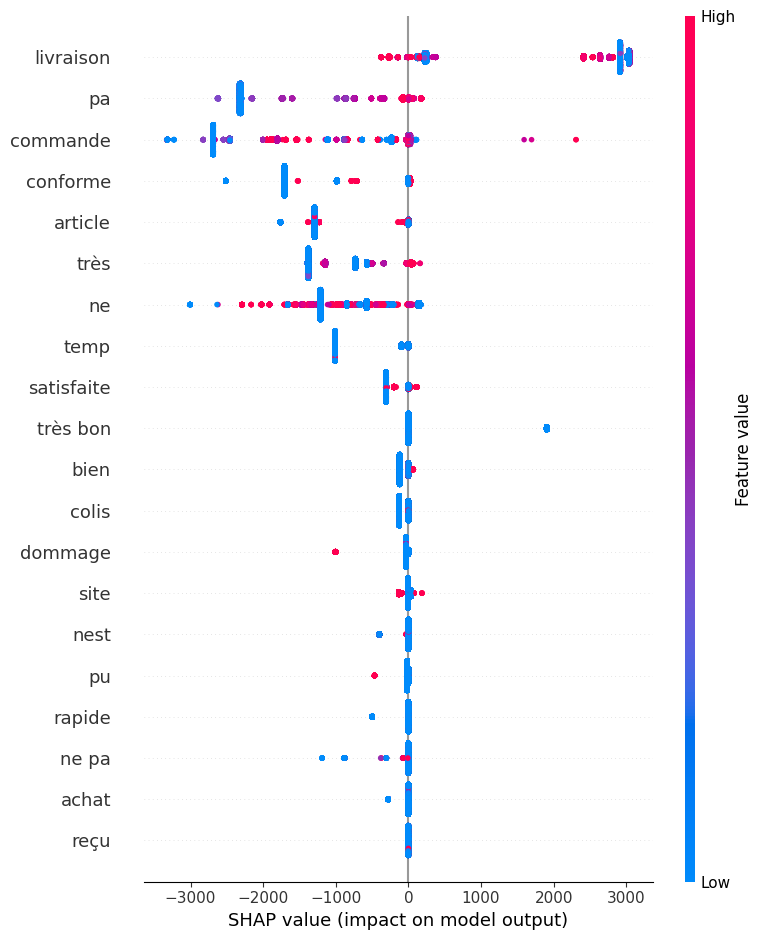

In [ ]:
# Interprétabilité via Shap
explainer = shap.TreeExplainer(clf, data=X_test.toarray())
shap_values = explainer.shap_values(X_test.todense(), approximate=True, check_additivity=False)
shap.summary_plot(shap_values, X_test.toarray(), feature_names=vectorizer.get_feature_names_out())

##Word-Embedding

> ### KNN sur données standardisées

In [ ]:
# Nécessite l'execution de la section Transformation des données

# ou importation des données transformées
try:
  df = pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/data_preparee2.csv', index_col=[0]) #ligne pour récupérer les données sur G-Drive
except:
  df = pd.read_csv('data_preparee2.csv', index_col=[0])

In [ ]:
df=df.dropna(axis=0,how='any')
df=df.rename(columns={"Commentaire":"Text"})
df['Text'] = df['Text'].apply(lambda x: ' '.join(re.findall(r"'(\w+)'", x)))
df['Sentiment'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)
df=df[["Text","Sentiment"]]
df["Text"].fillna('', inplace=True)

# Création d'une liste qui contient des phrases tokenisées, représentées en liste de mots
sentences = [text_to_word_sequence(comment) for comment in df['Text']]
cores = multiprocessing.cpu_count()

# Instanciation du modèle Word Embedding avec un espace vectoriel de dimension 4000, avec un minimu d'occurrence à 50 pour qu'un mot soit pris en compte
model = Word2Vec(sentences, workers=cores-1, vector_size=4000, min_count=50, window=5)
model.build_vocab(sentences, progress_per=10000)
model.train(sentences, total_examples=model.corpus_count, epochs=30, report_delay=1)

# Dump du Word2Vec
joblib.dump(model.wv, 'w2v_4000.pkl')

X = []
# Si des vecteurs sont extraits, on prend la moyenne de ces vecteurs pour obtenir une représentation vectorielle pour la phrase
# Si un mot n'est pas trouvé dans le modèle ,on ajoutez un vecteur nul à la liste.
for words in sentences:
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
      X.append(np.mean(vectors, axis=0))
    else:
      X.append(np.zeros(model.vector_size))

# transformation de la liste en une colonne,concaténée verticalement
X = np.vstack(X)
y = df['Sentiment']

# Application de l'ACP pour réduire la dimensionnalité
pca = PCA(n_components = 0.9)
X_pca = pca.fit_transform(X)
print("Nombre de composantes retenues :", pca.n_components_)

# Dump de la PCA
joblib.dump(pca, 'w2v_pca_4000_90.pkl')

In [ ]:
# 'interprétabilité à l'étape de l'ACP'

components_variances = np.var(pca.components_, axis=0)
sorted_words_indices = np.argsort(components_variances)[::-1]

top_words = [model.wv.index_to_key[i] for i in sorted_words_indices[:14]]
print("Top mots de la première composante principale :", top_words)

In [ ]:
# Division des données en ensemble de test et d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform( X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
knn = KNeighborsClassifier(metric='minkowski', n_jobs=-1)
knn.fit(X_train_scaled,y_train)
y_pred = knn.predict(X_test_scaled)

# Calcul et affichage de classification_report
print( classification_report(y_test, y_pred) )

# Calcul et affichage de la matrice de confusion
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.79      0.84      0.81     16901
           1       0.89      0.85      0.87     25322

    accuracy                           0.85     42223
   macro avg       0.84      0.85      0.84     42223
weighted avg       0.85      0.85      0.85     42223



Classe prédite      0      1
Classe réelle               
0               14159   2742
1                3732  21590

In [ ]:
print("le score sur l'échantillon train est :", round(knn.score(X_train, y_train),2) )
print("le score sur l'échantillon test est :", round(knn.score(X_test, y_test),2) )

le score sur l'échantillon train est : 0.88
le score sur l'échantillon test est  : 0.85


In [ ]:
y_pred_train = knn.predict(X_train)
y_pred_test  = knn.predict(X_test)

print(' mean_squared_error train :', round(mean_squared_error(y_pred_train, y_train),2))
print(' mean_squared_error test :', round( mean_squared_error(y_pred_test, y_test), 2))

 mean_squared_error train : 0.12
 mean_squared_error test  : 0.15


> ### Random Forest sur données standardisées

In [ ]:
# Nécessite l'execution de la section Transformation des données

# ou importation des données transformées
try:
  df = pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/data_preparee2.csv', index_col=[0]) #ligne pour récupérer les données sur G-Drive
except:
  df = pd.read_csv('data_preparee2.csv', index_col=[0])

In [ ]:
# Importation des modèles calculés dans la section "Word-Embedding et Random Forest"

try:
    model=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_4000.pkl')
    pca=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_pca_4000_90.pkl')

except:
    model=joblib.load('w2v_4000.pkl')
    pca=joblib.load('w2v_pca_4000_90.pkl')

df=df.dropna(axis=0,how='any')
df=df.rename(columns={"Commentaire":"Text"})
df['Text'] = df['Text'].apply(lambda x: ' '.join(re.findall(r"'(\w+)'", x)))
df['Sentiment'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)
df=df[["Text","Sentiment"]]
df["Text"].fillna('', inplace=True)

X = []
# Si des vecteurs sont extraits, on prend la moyenne de ces vecteurs pour obtenir une représentation vectorielle pour la phrase
# Si un mot n'est pas trouvé dans le modèle ,on ajoutez un vecteur nul à la liste.
for words in sentences:
    vectors = [model[word] for word in words if word in model]
    if vectors:
      X.append(np.mean(vectors, axis=0))
    else:
      X.append(np.zeros(model.vector_size))

# transformation de la liste en une colonne,concaténée verticalement
X = np.vstack(X)
y = df['Sentiment']

#Transformation des données via le modèle d'ACP entrainé
X_pca = pca.transform(X)

# Division des données en ensemble de test et d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform( X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
rf_scale = RandomForestClassifier()
rf_scale.fit(X_train_scaled, y_train)

y_pred = rf_scale.predict(X_test_scaled)

# Calcul et affichage de classification_report
print( classification_report(y_test, y_pred) )

# Calcul et affichage de la matrice de confusion
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.84      0.78      0.80     16901
           1       0.86      0.90      0.88     25322

    accuracy                           0.85     42223
   macro avg       0.85      0.84      0.84     42223
weighted avg       0.85      0.85      0.85     42223



Classe prédite      0      1
Classe réelle               
0               13106   3795
1                2588  22734

In [ ]:
print("le score sur l'échantillon train est :", round(rf_scale.score(X_train_scaled, y_train),2) )
print("le score sur l'échantillon test est :", round(rf_scale.score(X_test_scaled, y_test), 2) )

le score sur l'échantillon train est : 0.99
le score sur l'échantillon test est  : 0.85


In [ ]:
y_pred_train = rf_scale.predict(X_train)
y_pred_test  = rf_scale.predict(X_test)

print(' mean_squared_error train :', round(mean_squared_error(y_pred_train, y_train), 2))
print(' mean_squared_error test :', round(mean_squared_error(y_pred_test, y_test), 2))

 mean_squared_error train : 0.16
 mean_squared_error test  : 0.17


> ### Random Forest sur données non-standardisées

In [ ]:
# Nécessite l'execution de la section Transformation des données

# ou importation des données transformées
try:
  df = pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/data_preparee2.csv', index_col=[0]) #ligne pour récupérer les données sur G-Drive
except:
  df = pd.read_csv('data_preparee2.csv', index_col=[0])

In [ ]:
# Importation des modèles calculés dans la section "Word-Embedding et Random Forest"

try:
    model=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_4000.pkl')
    pca=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_pca_4000_90.pkl')

except:
    model=joblib.load('w2v_4000.pkl')
    pca=joblib.load('w2v_pca_4000_90.pkl')

df=df.dropna(axis=0,how='any')
df=df.rename(columns={"Commentaire":"Text"})
df['Text'] = df['Text'].apply(lambda x: ' '.join(re.findall(r"'(\w+)'", x)))
df['Sentiment'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)
df=df[["Text","Sentiment"]]
df["Text"].fillna('', inplace=True)

X = []
# Si des vecteurs sont extraits, on prend la moyenne de ces vecteurs pour obtenir une représentation vectorielle pour la phrase
# Si un mot n'est pas trouvé dans le modèle ,on ajoutez un vecteur nul à la liste.
for words in sentences:
    vectors = [model[word] for word in words if word in model]
    if vectors:
      X.append(np.mean(vectors, axis=0))
    else:
      X.append(np.zeros(model.vector_size))

# transformation de la liste en une colonne,concaténée verticalement
X = np.vstack(X)
y = df['Sentiment']

#Transformation des données via le modèle d'ACP entrainé
X_pca = pca.transform(X)

# Division des données en ensemble de test et d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)

In [ ]:
rf = RandomForestClassifier(n_estimators=200, criterion='gini',  max_depth=9, max_features=20, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Calcul et affichage de classification_report
print( classification_report(y_test, y_pred) )

# Calcul et affichage de la matrice de confusion
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.83      0.74      0.78     16901
           1       0.84      0.90      0.87     25322

    accuracy                           0.84     42223
   macro avg       0.83      0.82      0.83     42223
weighted avg       0.83      0.84      0.83     42223



Classe prédite      0      1
Classe réelle               
0               12569   4332
1                2622  22700

In [ ]:
print("le score sur l'échantillon train est :", round(rf.score(X_train, y_train),2) )
print("le score sur l'échantillon test est :", round(rf.score(X_test, y_test), 2) )

le score sur l'échantillon train est : 0.85
le score sur l'échantillon test est  : 0.84


In [ ]:
y_pred_train = rf.predict(X_train)
y_pred_test  = rf.predict(X_test)

print(' mean_squared_error train :', round(mean_squared_error(y_pred_train, y_train), 2))
print(' mean_squared_error test :', round(mean_squared_error(y_pred_test, y_test), 2))

 mean_squared_error train : 0.15
 mean_squared_error test  : 0.16


> ### Word-Embedding et Random Forest

In [ ]:
# Nécessite l'execution de la section Transformation des données

# ou importation des données transformées
try:
  df = pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/data_preparee2.csv', index_col=[0]) #ligne pour récupérer les données sur G-Drive
except:
  df = pd.read_csv('data_preparee2.csv', index_col=[0])

In [ ]:
# Importation des modèles calculés dans la section "Word-Embedding et Random Forest"

try:
    model=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_4000.pkl')
    pca=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_pca_4000_90.pkl')

except:
    model=joblib.load('w2v_4000.pkl')
    pca=joblib.load('w2v_pca_4000_90.pkl')

df=df.dropna(axis=0,how='any')
df=df.rename(columns={"Commentaire":"Text"})
df['Text'] = df['Text'].apply(lambda x: ' '.join(re.findall(r"'(\w+)'", x)))
df['Sentiment'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)
df=df[["Text","Sentiment"]]
df["Text"].fillna('', inplace=True)

X = []
# Si des vecteurs sont extraits, on prend la moyenne de ces vecteurs pour obtenir une représentation vectorielle pour la phrase
# Si un mot n'est pas trouvé dans le modèle ,on ajoutez un vecteur nul à la liste.
for words in sentences:
    vectors = [model[word] for word in words if word in model]
    if vectors:
      X.append(np.mean(vectors, axis=0))
    else:
      X.append(np.zeros(model.vector_size))

# transformation de la liste en une colonne,concaténée verticalement
X = np.vstack(X)
y = df['Sentiment']

#Transformation des données via le modèle d'ACP entrainé
X_pca = pca.transform(X)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Nombre de composantes retenues : 125


['w2v_pca_4000_90.pkl']

In [ ]:
# Division des données en ensemble de test et d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)

# Modèle de RandomForest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Affichage des résultats
print( classification_report(y_test, y_pred) )
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.84      0.79      0.81     16901
           1       0.86      0.90      0.88     25322

    accuracy                           0.86     42223
   macro avg       0.85      0.84      0.85     42223
weighted avg       0.85      0.86      0.85     42223



Classe prédite      0      1
Classe réelle               
0               13277   3624
1                2483  22839

> ### Word-Embedding et XGBoost

In [ ]:
# Nécessite l'execution de la section Transformation des données

# ou importation des données transformées
try:
  df = pd.read_csv('/content/drive/MyDrive/Colab_supply_chain/Data/data_preparee2.csv', index_col=[0]) #ligne pour récupérer les données sur G-Drive
except:
  df = pd.read_csv('data_preparee2.csv', index_col=[0])


In [ ]:
# Importation des modèles calculés dans la section "Word-Embedding et Random Forest"

try:
    model=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_4000.pkl')
    pca=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_pca_4000_90.pkl')

except:
    model=joblib.load('w2v_4000.pkl')
    pca=joblib.load('w2v_pca_4000_90.pkl')

df=df.dropna(axis=0,how='any')
df=df.rename(columns={"Commentaire":"Text"})
df['Text'] = df['Text'].apply(lambda x: ' '.join(re.findall(r"'(\w+)'", x)))
df['Sentiment'] = df['star'].apply(lambda x: 1 if x >= 4 else 0)
df=df[["Text","Sentiment"]]
df["Text"].fillna('', inplace=True)

X = []
# Si des vecteurs sont extraits, on prend la moyenne de ces vecteurs pour obtenir une représentation vectorielle pour la phrase
# Si un mot n'est pas trouvé dans le modèle ,on ajoutez un vecteur nul à la liste.
for words in sentences:
    vectors = [model[word] for word in words if word in model]
    if vectors:
      X.append(np.mean(vectors, axis=0))
    else:
      X.append(np.zeros(model.vector_size))

# transformation de la liste en une colonne,concaténée verticalement
X = np.vstack(X)
y = df['Sentiment']

#Transformation des données via le modèle d'ACP entrainé
X_pca = pca.transform(X)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Division des données en ensemble de test et d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)


# # Paramètres du GRID Search

# param_grid = {
#     'n_estimators': [40,60,80,100,125,150,175,200,300,400,500,1000],
#     'learning_rate': [1,0.5,0.25,0.225,0.015,0.1,0.05,0.01],
#     'max_depth': [4,5,6,7,8,9],
#     'n_jobs' : -1,
#     'tree_method':'gpu_hist'
# }

# clf = xgb.XGBClassifier(n_jobs=-1)
# grid_search = GridSearchCV(clf, param_grid, cv=3)
# grid_search.fit(X_train, y_train)

# print("Meilleurs paramètres : ", grid_search.best_params_)
# clf = grid_search.best_estimator_
# y_pred = clf.predict(X_test)

# # Récupération des scores d'accuracy
# accuracies = grid_search.cv_results_['mean_test_score']

# # Création du graphique
# plt.plot(range(len(accuracies)), accuracies)
# plt.xlabel('Test')
# plt.ylabel('Accuracy')
# plt.title('Scores d\'accuracy de chaque test de la validation croisée')
# plt.show()


# Meilleur modèle après Grid Search :
clf = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.225,
    max_depth=5,
    n_jobs=-1,
    tree_method='gpu_hist'
    )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Affichage des résultats
print( classification_report(y_test, y_pred) )
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

# Dump du modèle
joblib.dump(pca, 'w2v_pca_4000_90.pkl')

              precision    recall  f1-score   support

           0       0.84      0.83      0.84     16901
           1       0.89      0.89      0.89     25322

    accuracy                           0.87     42223
   macro avg       0.87      0.86      0.87     42223
weighted avg       0.87      0.87      0.87     42223



['w2v_pca_4000_90.pkl']

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


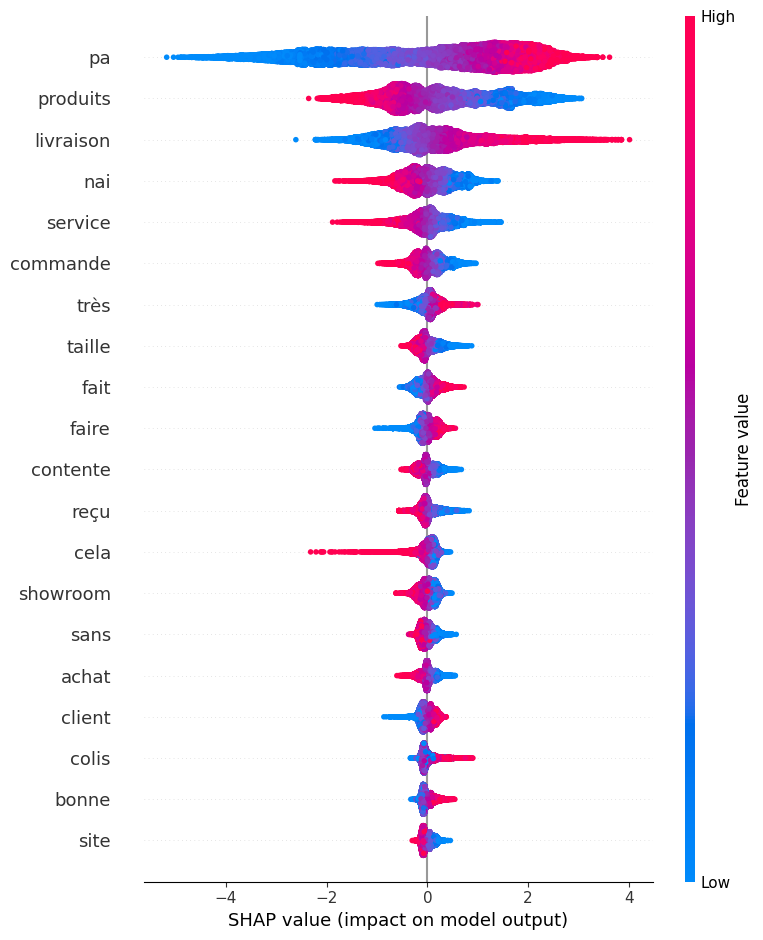

In [ ]:
# Interprétabilité globale du modèle

explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)

# Indice des features les plus importants identifiés utilisées par l'XGBoost
selected_feature_indices = np.argsort(clf.feature_importances_)[::-1]#[::-1] pour obtenir la liste triée dans l'ordre décroissant
# Récupération des mots associés aux features les plus importants
top_words = [model.index_to_key[i] for i in selected_feature_indices]

shap.summary_plot(shap_values, X_test, feature_names=top_words)

In [ ]:
# Interprétabilité locale du modèle

explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)

# Indice du commentaire étudié
comment_index = 50

# Récupération des features les plus importants identifiés par l'ACP et utilisés par l'XGBoost
selected_feature_indices = np.argsort(clf.feature_importances_)[::-1][:138]#138 car après ACP -> dimension de 138
# Récupération des indices des mots associés aux features les plus importants identifiés par l'ACP
selected_word_indices = selected_feature_indices[:X_pca.shape[1]]
# Récupération des mots associés aux features les plus importants
top_words = [model.index_to_key[i] for i in selected_word_indices]

# Affichage du commentaire étudié
print("Commentaire :", df['Text'].iloc[comment_index])

# Prédiction du modèle pour le commentaire étudié
prediction = clf.predict(X_test[comment_index].reshape(1, -1))[0]
if prediction == 1:
    print("Sentiment prédit : Positif")
else:
    print("Sentiment prédit : Négatif")

# Affichage de la vraie classe (étiquette réelle) du commentaire étudié
true_class = y_test.iloc[comment_index]
if true_class == 1:
    print("Vraie classe : Positif")
else:
    print("Vraie classe : Négatif")

# Affichage des explications pour l'observation :
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[comment_index][:X_pca.shape[1]], X_test[comment_index], feature_names=top_words)

Commentaire : ravie produits soin corporel main marque nivea ainsi qualité lenvoi tout attendu peu tout comme sil venait bout monde lessentiel cependant satisfaction
Sentiment prédit : Négatif
Vraie classe : Négatif


# **Test du modèle**

In [ ]:
# Chargement des modèles
import joblib
try:
    word2vec_model=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_4000.pkl')
    xgb_model=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_clf_pca_4000_150_0225_5.pkl')
    pca_model=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_pca_4000_90.pkl')

except:
    word2vec_model=joblib.load('w2v_4000.pkl')
    xgb_model=joblib.load('w2v_clf_pca_4000_150_0225_5.pkl')
    pca_model=joblib.load('w2v_pca_4000_90.pkl')

joblib.dump(word2vec_model, 'w2v_4000.pkl')
joblib.dump(xgb_model, 'w2v_clf_pca_4000_150_0225_5.pkl')
joblib.dump(pca_model, 'w2v_pca_4000_90.pkl')


['w2v_pca_4000_90.pkl']

In [ ]:
# Commentaires à tester :
comments = ["Service client mauvais",
            "délai de réponse long",
           "livraison à la mauvaise adresse",
            "colis endommagé",
            "erreur de facturation",
            "ne correspond pas au descriptif",
            "Site non responsive",
            "pas d'erreur de commande",
            "Je n'ai jamais été insatisfaite de mes commandes",
            "Je suis insatisfait",
            "Je ne suis pas satisfait",
            "insatisfait",
            "problème de remboursement",
            "commande incomplète",
            "Beaucoup de choix de vêtements et accessoires, et des petits prix intéressant",
            "accessible à tous",
            "une horreur !!",
            "livraison longue",
            "charmant conseillé",
            "produit toxique",
            "colis perdu",
            "inadmissible",
            "Pas de réponse du service client",
            "transporteur pas fiable",
            "j'aime beaucoup",
            "aucun retour service client",
            "impossible de renvoyer mes articles, super génial, whaou merci beaucoup !!",
            "personne ne me répond",
            "je suis vraiment déçu",
            "Réponse non courtoise",
            "belle arnaque !",
             "arnaque !!!!",
          ]



# Fonctions de nettoyage et lemmatisation des commentaires

def clean_text(text):
    text = " ".join(text.split())
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def preprocess_comments(comments):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('french'))
    stop_words.update(['a', "jai", "cest", "sest", "car", "donc"])
    stop_words.difference_update(["pas"])

    preprocessed_comments = []
    for comment in comments:
        comment = clean_text(comment)
        word_tokens = word_tokenize(comment, language="french")
        filtered_sentence = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words and w.isalpha()]
        preprocessed_comments.append(filtered_sentence)

    return preprocessed_comments

# Application du prétraitement sur les commentaires de test
preprocessed_comments = preprocess_comments(comments)

# Calcule des vecteurs d'embedding pour chaque commentaire
comment_vectors = []
for words in preprocessed_comments:
    vectors = [word2vec_model[word] for word in words if word in word2vec_model]
    if vectors:
        comment_vectors.append(np.mean(vectors, axis=0))
    else:
        comment_vectors.append(np.zeros(word2vec_model.vector_size))

# Empilage des vecteurs pour obtenir un tableau 2D
comment_vectors = np.vstack(comment_vectors)

# Application de l' ACP
comment_vectors_pca = pca_model.transform(comment_vectors)

# Calcul des prédictions
predicted_sentiments = xgb_model.predict(comment_vectors_pca)

# Affichage des résultats
for comment, sentiment in zip(comments, predicted_sentiments):
    print(f"Commentaire: {comment}")
    print(f"Sentiment prédit: {'Positive' if sentiment == 1 else 'Negative'}")
    print()

Commentaire: Service client mauvais
Sentiment prédit: Negative

Commentaire: délai de réponse long
Sentiment prédit: Positive

Commentaire: livraison à la mauvaise adresse
Sentiment prédit: Negative

Commentaire: colis endommagé
Sentiment prédit: Negative

Commentaire: erreur de facturation
Sentiment prédit: Negative

Commentaire: ne correspond pas au descriptif
Sentiment prédit: Positive

Commentaire: Site non responsive
Sentiment prédit: Negative

Commentaire: pas d'erreur de commande
Sentiment prédit: Negative

Commentaire: Je n'ai jamais été insatisfaite de mes commandes
Sentiment prédit: Positive

Commentaire: Je suis insatisfait
Sentiment prédit: Positive

Commentaire: Je ne suis pas satisfait
Sentiment prédit: Positive

Commentaire: insatisfait
Sentiment prédit: Positive

Commentaire: problème de remboursement
Sentiment prédit: Negative

Commentaire: commande incomplète
Sentiment prédit: Negative

Commentaire: Beaucoup de choix de vêtements et accessoires, et des petits prix int

# **Streamlit avec Colab**

In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.6/188.6 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 35.9 MB/s eta 0:00:00


In [ ]:
# Chargement des modèles
# Si utilisation de Google Colab :
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Drive non connecté")

import joblib
try:
    word2vec_model=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_4000.pkl')
    xgb_model=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_clf_pca_4000_150_0225_5.pkl')
    pca_model=joblib.load('/content/drive/MyDrive/Colab_supply_chain/Notebooks/w2v_pca_4000_90.pkl')

    # Dumper pour avoir les modèles accessibles pour streamlit
    joblib.dump(word2vec_model, 'w2v_4000.pkl')
    joblib.dump(xgb_model, 'w2v_clf_pca_4000_150_0225_5.pkl')
    joblib.dump(pca_model, 'w2v_pca_4000_90.pkl')

except:
    word2vec_model=joblib.load('w2v_4000.pkl')
    xgb_model=joblib.load('w2v_clf_pca_4000_150_0225_5.pkl')
    pca_model=joblib.load('w2v_pca_4000_90.pkl')




Drive non connecté


In [ ]:
# Le code streamlit

%%writefile app.py
import streamlit as st
import string
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import joblib
import nltk
import time
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Chargement des modèles
word2vec_model = joblib.load('w2v_4000.pkl')
xgb_model = joblib.load('w2v_clf_pca_4000_150_0225_5.pkl')
pca_model = joblib.load('w2v_pca_4000_90.pkl')

# Configuration de la page d'accueil
st.set_page_config(page_title="Projet Supply Chain - Analyse de sentiments", page_icon="🧐")

# Menu de navigation
menu_choice = st.sidebar.radio("Menu", ["Accueil", "Objectifs", "Présentation du modèle", "Test du modèle"])

# Contenu de la page en fonction du choix de menu
if menu_choice == "Accueil":
    st.title("Projet Supply Chain - Analyse de sentiments")
    st.write("DataScientest")
    st.subheader("Cohorte de novembre 2022 - parcours Data Scientist")
    st.write("Projet réalisé par Adnane MOUZAOUI et François ROUXELIN")
    st.write("Coordonné par Yohan COHEN")



elif menu_choice == "Objectifs":
    st.title(" Objectif de l'étude : ")
    st.write(
    """ ### Développer un modèle prédictif d'analyse de sentiments basés sur des commentaires laissés par les clients

    L'objectif principal de notre étude est de développer un modèle prédictif
    performant pour évaluer la satisfaction des clients à partir de commentaires.

    Dans le cadre de notre analyse, nous chercherons à comprendre les variables
    qui peuvent avoir un impact sur la satisfaction client, en examinant divers
    aspects des commentaires tels que la taille, la ponctuation,
    la présence de majuscules, etc.

    Nous effectuerons également une étape de nettoyage des données, en enlevant
    les mots sans signification ou redondants tels que les stopwords, et en
    utilisant la lemmatisation pour normaliser les mots.

    En somme, nous chercherons à comprendre les facteurs clés qui contribuent
    à la satisfaction des clients et à développer un modèle prédictif robuste
    pour prédire leur note directement à partir de leurs commentaires.

    Cette étude présente des enjeux économiques, techniques et scientifiques
    importants, en permettant notamment aux entreprises de mieux comprendre les
    besoins de leurs clients et d'adapter leur offre en conséquence.

    #### →  Extraire les propos des clients

    #### → Identifier les composants importants d’un message

    #### → Prédire le sentiment de la satisfaction client

    """
    )




elif menu_choice == "Présentation du modèle":
    st.title(" Présnetation du modèle :")
    st.write(
      """"
      ### étaope de modèlisation :

      Dans Cette étape, nous avons testé plusieurs modèles à la recherche de
      l'algorithme obteannt le meilleur score:
      Knn plus proche voisin, Randomforest, Gradient boost, Xgboost

      Ces algorithmes ont été entrainés sous plusieurs configurations:
      - Utilisation du dataset de base avec création de nouvelles variables pour
        les métadonnées( longueur titre, nombre mots, ponctuation, ...)

      - Avec vectorisation des commentaires avec un Bag-of-words

      - Avec vectorisation des commentaires avec l'algorithme Word-Embedding
        et word-embedding avec n-gram allant de 1 à 4.

      - utilisation de l'algoritme TF-IDF


      ### Le modèle retenu :

      Plusieurs ajustements ont été fait sur les hyperparamètres en utilisant
      différentes combinaisons dans une grille de recherche (grid-search).
      la meilleure combinaison obtenue s'applique en utilisant l'algorithme :

      XGBoost avec : Learning rate de 0,225, Profondeur 5 et 150 estimateurs

      """
      )





elif menu_choice == "Test du modèle":
    st.title("Vous pouvez tester le modèle !")
    comment = st.text_area("Entrez votre commentaire ici:")
    if st.button("Analyser"):
        if comment.strip() == "":
            st.write("Merci de saisir un commentaire")
        else:
            def clean_text(text):
                text = " ".join(text.split())
                text = text.lower()
                text = text.translate(str.maketrans('', '', string.punctuation))
                return text

            def preprocess_comment(comment):
                lemmatizer = WordNetLemmatizer()
                stop_words = set(stopwords.words('french'))
                stop_words.update(['a', "jai", "cest", "sest", "car", "donc"])
                stop_words.difference_update(["pas"])

                comment = clean_text(comment)
                word_tokens = word_tokenize(comment, language="french")
                filtered_sentence = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words and w.isalpha()]
                return filtered_sentence

            preprocessed_comment = preprocess_comment(comment)
            comment_vector = np.mean([word2vec_model[word] for word in preprocessed_comment if word in word2vec_model], axis=0)
            if not np.isnan(comment_vector).any():
                comment_vector_pca = pca_model.transform(comment_vector.reshape(1, -1))
                predicted_sentiment_prob = xgb_model.predict_proba(comment_vector_pca)[0][1]  # Probabilité de classe 1
                predicted_sentiment = xgb_model.predict(comment_vector_pca)
                predicted_sentiment_prob *=100

                if predicted_sentiment == 1:
                    sentiment_str = "Plutôt positif   :"+ " :smile:"
                else:
                    sentiment_str = "Plutôt négatif"

                st.write(f"Sentiment prédit: {sentiment_str}")


                progress_text = "Operation in progress. Please wait."
                my_bar = st.progress(0, text=progress_text)
                for percent_complete in range(int(predicted_sentiment_prob)):
                    time.sleep(0.1)
                    if percent_complete != int(predicted_sentiment_prob):
                        my_bar.progress(percent_complete + 1, text=progress_text)
                    else:
                        my_bar.progress(percent_complete , text="Complete")




                st.write(f"Probabilité de classe positive: {predicted_sentiment_prob:.0f} %")
            else:
                st.write("Impossible d'évaluer ce commentaire")

Overwriting app.py


In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.475s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [ ]:
!streamlit run /content/app.py &>/content/logs.txt & curl ipv4.icanhazip.com

34.142.214.114


In [ ]:
!npx localtunnel --port 8501

npx: installed 22 in 1.13s
your url is: https://dirty-tables-raise.loca.lt
